In [1]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

In [2]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

In [3]:
def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        tokens = tokenizer(str(text), truncation=False, return_tensors="pt")
        token_lengths.append(len(tokens['input_ids'][0]))
    
    return pd.Series(token_lengths, index=texts.index)


In [4]:
def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        pd.Series: Filtered texts with outliers removed
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Define upper and lower bounds
    upper_bound = mean_length + std_threshold * std_length
    lower_bound = mean_length - std_threshold * std_length
    lower_bound = max(1, lower_bound)  # Ensure lower bound is at least 1
    
    # Create mask for samples within bounds
    mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
    
    # Apply minimum token threshold if specified
    if min_token_threshold is not None:
        min_token_mask = token_lengths >= min_token_threshold
        mask = mask & min_token_mask
        print(f"Applying minimum token threshold of {min_token_threshold}")
        print(f"Removed {(~min_token_mask).sum()} samples below minimum token threshold")
    
    # Filter texts
    filtered_texts = texts[mask].reset_index(drop=True)
    removed_count = len(texts) - len(filtered_texts)

    # Get filtered token lengths
    filtered_token_lengths = token_lengths[mask].reset_index(drop=True)

    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    print(f"Applied {std_threshold} std dev threshold: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"Removed {removed_count} samples ({removed_count/len(texts)*100:.2f}% of data)")

    print(f"\nToken length statistics after filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")

    return filtered_texts, mask


In [5]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }

In [6]:
class DeBERTaClassifier(nn.Module):
    """
    A classifier model based on DeBERTa for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # Note: DeBERTa has a different architecture than BERT/RoBERTa
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Unlike BERT, DeBERTa doesn't have a pooler, so we need to take the last hidden state
        # and either use the [CLS] token (first token) or do mean pooling
        # Here we'll use the [CLS] token (first token) representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(cls_output)

In [7]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

In [8]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False

In [9]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

In [10]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

In [11]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Filter out infrequent labels, samples with too many labels, and token length outliers.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.
        tokenizer: Tokenizer to use for token length calculation (required if token_std_threshold is provided)
        token_std_threshold (float, optional): Standard deviation threshold for filtering token length outliers.
            If None, no token length filtering is applied. Common values are 2.0 or 3.0.
        min_token_threshold (int, optional): Minimum number of tokens required for a sample.
            If None, no minimum token threshold is applied.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Print initial dataset size
    initial_size = len(df)
    print(f"\n=== DATA PREPROCESSING STATISTICS ===")
    print(f"Initial dataset size: {initial_size}")
    
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        before_nan_filter = len(df)
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
        nan_removed = before_nan_filter - len(df)
        if nan_removed > 0:
            print(f"Step 1: Removed {nan_removed} rows with 'nan' text ({nan_removed/before_nan_filter*100:.2f}% of data)")
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    before_na_drop = len(df)
    df = df.dropna()
    na_removed = before_na_drop - len(df)
    if na_removed > 0:
        print(f"Step 2: Removed {na_removed} rows with missing labels ({na_removed/before_na_drop*100:.2f}% of data)")
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    current_size = len(texts)
    print(f"Dataset size after basic cleaning: {current_size} ({current_size/initial_size*100:.2f}% of original data)")

    # Filter by token length if requested
    if (token_std_threshold is not None or min_token_threshold is not None) and tokenizer is not None:
        print(f"\nStep 3: Filtering by token length...")
        if token_std_threshold is not None:
            print(f"Using {token_std_threshold} standard deviation threshold")
        if min_token_threshold is not None:
            print(f"Using minimum token threshold of {min_token_threshold}")
        
        # Calculate token lengths
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Apply token length filtering
        before_token_filter = len(texts)
        texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=min_token_threshold
        )
        # Apply same filter to labels
        labels = labels[token_mask].reset_index(drop=True)
        token_removed = before_token_filter - len(texts)
        print(f"Removed {token_removed} samples by token length filtering ({token_removed/before_token_filter*100:.2f}% of data)")
        print(f"Texts after token length filtering: {len(texts)} ({len(texts)/initial_size*100:.2f}% of original data)")

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])
    total_labels_before = len(label_distribution)
    print(f"\nStep 4: Filtering infrequent labels (min frequency: {min_label_freq})")
    print(f"Total unique labels before filtering: {total_labels_before}")

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    labels_removed = total_labels_before - len(frequent_labels)
    print(f"Removed {labels_removed} infrequent labels ({labels_removed/total_labels_before*100:.2f}% of labels)")
    print(f"Number of labels remaining: {len(frequent_labels)} ({len(frequent_labels)/total_labels_before*100:.2f}% of labels)")

    # Filter out infrequent labels
    before_label_filter = len(labels)
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Count samples that have no labels after filtering
    empty_labels_mask = filtered_labels.apply(len) > 0
    empty_labels_count = (~empty_labels_mask).sum()
    if empty_labels_count > 0:
        print(f"Warning: {empty_labels_count} samples ({empty_labels_count/before_label_filter*100:.2f}%) now have no labels due to label frequency filtering")
    
    print(f"Samples remaining after label filtering: {empty_labels_mask.sum()} ({empty_labels_mask.sum()/before_label_filter*100:.2f}% of data)")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    total_combinations_before = len(label_combinations)
    
    print(f"\nStep 5: Filtering infrequent label combinations (min frequency: {min_label_comb_freq})")
    print(f"Total unique label combinations before filtering: {total_combinations_before}")
    
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    combinations_removed = total_combinations_before - len(frequent_combinations)
    print(f"Removed {combinations_removed} infrequent label combinations ({combinations_removed/total_combinations_before*100:.2f}% of combinations)")
    print(f"Number of label combinations remaining: {len(frequent_combinations)} ({len(frequent_combinations)/total_combinations_before*100:.2f}% of combinations)")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        before_comb_filter = len(filtered_labels)
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        samples_removed_by_comb = before_comb_filter - comb_mask.sum()
        print(f"Removed {samples_removed_by_comb} samples with infrequent label combinations ({samples_removed_by_comb/before_comb_filter*100:.2f}% of data)")
        print(f"Samples remaining after combination filtering: {comb_mask.sum()} ({comb_mask.sum()/before_comb_filter*100:.2f}% of data)")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    print(f"\nStep 6: Filtering samples with too many labels (max labels per sample: {max_label_len})")
    before_length_filter = len(filtered_labels)
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    samples_removed_by_length = before_length_filter - length_mask.sum()
    print(f"Removed {samples_removed_by_length} samples with too many or zero labels ({samples_removed_by_length/before_length_filter*100:.2f}% of data)")
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"\n=== FINAL PREPROCESSING RESULTS ===")
    print(f"Original dataset size: {initial_size}")
    print(f"Final dataset size: {len(filtered_labels)} ({len(filtered_labels)/initial_size*100:.2f}% of original data)")
    print(f"Total samples removed: {initial_size - len(filtered_labels)} ({(initial_size - len(filtered_labels))/initial_size*100:.2f}% of original data)")
    
    return texts, filtered_labels


In [12]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Load the tokenizer for token length calculations
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Extract issue texts and labels
    texts = df[args.text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Determine token length filtering threshold based on args
    token_std_threshold = None
    if args.token_length_filter == '3std':
        token_std_threshold = 3.0
    elif args.token_length_filter == '2std':
        token_std_threshold = 2.0
    
    # Apply token length filtering first if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering...")
        token_lengths = calculate_token_lengths(texts, tokenizer)
        texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        # Apply same filter to labels
        labels = labels[token_mask].reset_index(drop=True)
        filtered_df = df.loc[token_mask].reset_index(drop=True)
    else:
        filtered_df = df
    
    # Apply token reduction if requested (after outlier removal)
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy: {args.token_reduction_strategy}")
        texts = process_with_token_reduction(
            texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_df with the reduced texts
        filtered_df[args.text_column] = texts
    
    # Use prepare_data function to filter and prepare data, but skip token length filtering since we've done it
    texts, filtered_labels = prepare_data(
        filtered_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Set to None to skip the token filtering in prepare_data
        min_token_threshold=args.min_token_threshold
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Save preprocessing metadata
    preprocessing_metadata = {
        'initial_dataset_size': len(df),
        'final_dataset_size': len(texts),
        'token_reduction': {
            'applied': args.token_reduction_strategy is not None,
            'strategy': args.token_reduction_strategy if args.token_reduction_strategy else None,
            'max_length': args.max_length
        },
        'token_length_filtering': {
            'applied': token_std_threshold is not None,
            'threshold': token_std_threshold
        },
        'label_filtering': {
            'min_label_freq': args.min_label_freq,
            'max_label_len': args.max_label_len,
            'min_label_comb_freq': args.min_label_comb_freq
        },
        'min_token_threshold': {
            'applied': args.min_token_threshold is not None,
            'threshold': args.min_token_threshold
        }
    }
    
    # Calculate and add max token length to metadata
    if tokenizer is not None:
        token_lengths = calculate_token_lengths(texts, tokenizer)
        max_token_length = int(token_lengths.max())
        preprocessing_metadata['token_stats'] = {
            'max_token_length': max_token_length,
            'mean_token_length': float(token_lengths.mean()),
            'median_token_length': float(token_lengths.median())
        }
        print(f"\n=== TOKEN LENGTH SUMMARY ===")
        print(f"Maximum token length: {max_token_length}")
        print(f"Mean token length: {token_lengths.mean():.2f}")
        print(f"Median token length: {token_lengths.median():.2f}")
    
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer, max_length=args.max_length)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer, max_length=args.max_length)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = DeBERTaClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'token_length_filter': args.token_length_filter,
        'token_reduction_strategy': args.token_reduction_strategy,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }


# Filter token length outlier

## 3 STD

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]


Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 303.06it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 21 samples (1.67% of data)

Token length statistics after filtering:
  Mean: 336.26, Std Dev: 279.70
  Min: 32, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 241.00
  75th percentile: 418.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1237
Dataset size after basic cleaning: 1237 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Samples remaining after label filtering: 1222 (98.79% of data)

Step 5: Filtering infrequent label combinations (min frequency: 2)
Total unique label combinations before filtering: 109
Removed 57 infrequent label combinations 

Calculating token lengths: 100%|██████████| 1156/1156 [00:02<00:00, 402.34it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1725
Mean token length: 325.18
Median token length: 231.50
Encoding labels...
Label density: 0.0672
Average labels per sample: 1.34
Training samples: 924, Validation samples: 232
Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


Train Loss: 0.5276, Train Accuracy (Exact Match): 0.0130
Val Loss: 0.2237
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


Train Loss: 0.2143, Train Accuracy (Exact Match): 0.0022
Val Loss: 0.1973
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 29/29 [00:43<00:00,  1.49s/it]


Train Loss: 0.2023, Train Accuracy (Exact Match): 0.0054
Val Loss: 0.1915
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 29/29 [00:45<00:00,  1.56s/it]


Train Loss: 0.1973, Train Accuracy (Exact Match): 0.0162
Val Loss: 0.1851
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 29/29 [00:47<00:00,  1.62s/it]


Train Loss: 0.1885, Train Accuracy (Exact Match): 0.0368
Val Loss: 0.1759
Val Accuracy (Exact Match): 0.0431
Val Accuracy (Partial Match): 0.0445
Val Accuracy (Jaccard): 0.0445
Val Precision: 0.0474, Val Recall: 0.0445, Val F1: 0.0453
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.1634, Train Accuracy (Exact Match): 0.2154
Val Loss: 0.1532
Val Accuracy (Exact Match): 0.2888
Val Accuracy (Partial Match): 0.3990
Val Accuracy (Jaccard): 0.3659
Val Precision: 0.4138, Val Recall: 0.3990, Val F1: 0.3923
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.1331, Train Accuracy (Exact Match): 0.3961
Val Loss: 0.1364
Val Accuracy (Exact Match): 0.3621
Val Accuracy (Partial Match): 0.4708
Val Accuracy (Jaccard): 0.4381
Val Precision: 0.4845, Val Recall: 0.4708, Val F1: 0.4641
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Train Loss: 0.1083, Train Accuracy (Exact Match): 0.5455
Val Loss: 0.1228
Val Accuracy (Exact Match): 0.4526
Val Accuracy (Partial Match): 0.5838
Val Accuracy (Jaccard): 0.5402
Val Precision: 0.5815, Val Recall: 0.5838, Val F1: 0.5696
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0924, Train Accuracy (Exact Match): 0.6342
Val Loss: 0.1177
Val Accuracy (Exact Match): 0.5431
Val Accuracy (Partial Match): 0.6657
Val Accuracy (Jaccard): 0.6272
Val Precision: 0.6698, Val Recall: 0.6657, Val F1: 0.6551
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.82s/it]


Train Loss: 0.0808, Train Accuracy (Exact Match): 0.6883
Val Loss: 0.1112
Val Accuracy (Exact Match): 0.5560
Val Accuracy (Partial Match): 0.6991
Val Accuracy (Jaccard): 0.6528
Val Precision: 0.7004, Val Recall: 0.6991, Val F1: 0.6852
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0741, Train Accuracy (Exact Match): 0.7100
Val Loss: 0.1107
Val Accuracy (Exact Match): 0.5690
Val Accuracy (Partial Match): 0.7217
Val Accuracy (Jaccard): 0.6695
Val Precision: 0.7151, Val Recall: 0.7217, Val F1: 0.7033
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0672, Train Accuracy (Exact Match): 0.7294
Val Loss: 0.1101
Val Accuracy (Exact Match): 0.5603
Val Accuracy (Partial Match): 0.7626
Val Accuracy (Jaccard): 0.6853
Val Precision: 0.7302, Val Recall: 0.7626, Val F1: 0.7270
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.82s/it]


Train Loss: 0.0621, Train Accuracy (Exact Match): 0.7435
Val Loss: 0.1077
Val Accuracy (Exact Match): 0.5733
Val Accuracy (Partial Match): 0.7616
Val Accuracy (Jaccard): 0.6967
Val Precision: 0.7537, Val Recall: 0.7616, Val F1: 0.7371
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.82s/it]


Train Loss: 0.0576, Train Accuracy (Exact Match): 0.7652
Val Loss: 0.1136
Val Accuracy (Exact Match): 0.5776
Val Accuracy (Partial Match): 0.7713
Val Accuracy (Jaccard): 0.6976
Val Precision: 0.7409, Val Recall: 0.7713, Val F1: 0.7377
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0552, Train Accuracy (Exact Match): 0.7673
Val Loss: 0.1101
Val Accuracy (Exact Match): 0.5517
Val Accuracy (Partial Match): 0.7713
Val Accuracy (Jaccard): 0.6904
Val Precision: 0.7453, Val Recall: 0.7713, Val F1: 0.7356

Epoch 16/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0512, Train Accuracy (Exact Match): 0.7879
Val Loss: 0.1059
Val Accuracy (Exact Match): 0.5733
Val Accuracy (Partial Match): 0.7648
Val Accuracy (Jaccard): 0.6976
Val Precision: 0.7517, Val Recall: 0.7648, Val F1: 0.7385
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.82s/it]


Train Loss: 0.0481, Train Accuracy (Exact Match): 0.8063
Val Loss: 0.1055
Val Accuracy (Exact Match): 0.5991
Val Accuracy (Partial Match): 0.7820
Val Accuracy (Jaccard): 0.7170
Val Precision: 0.7668, Val Recall: 0.7820, Val F1: 0.7557
Saved new best model to ./results/run_20250325_181359_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Early stopping triggered
Train Loss: 0.0457, Train Accuracy (Exact Match): 0.8171
Val Loss: 0.1069
Val Accuracy (Exact Match): 0.5819
Val Accuracy (Partial Match): 0.7820
Val Accuracy (Jaccard): 0.7091
Val Precision: 0.7603, Val Recall: 0.7820, Val F1: 0.7507
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


<ipython-input-12-74ef7e21d0bb>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5991
Partial Match Accuracy: 0.7820
Jaccard Similarity: 0.7170
Precision: 0.7668
Recall: 0.7820
F1 Score: 0.7557

Training completed! Results saved to ./results/run_20250325_181359_all_text_0.5


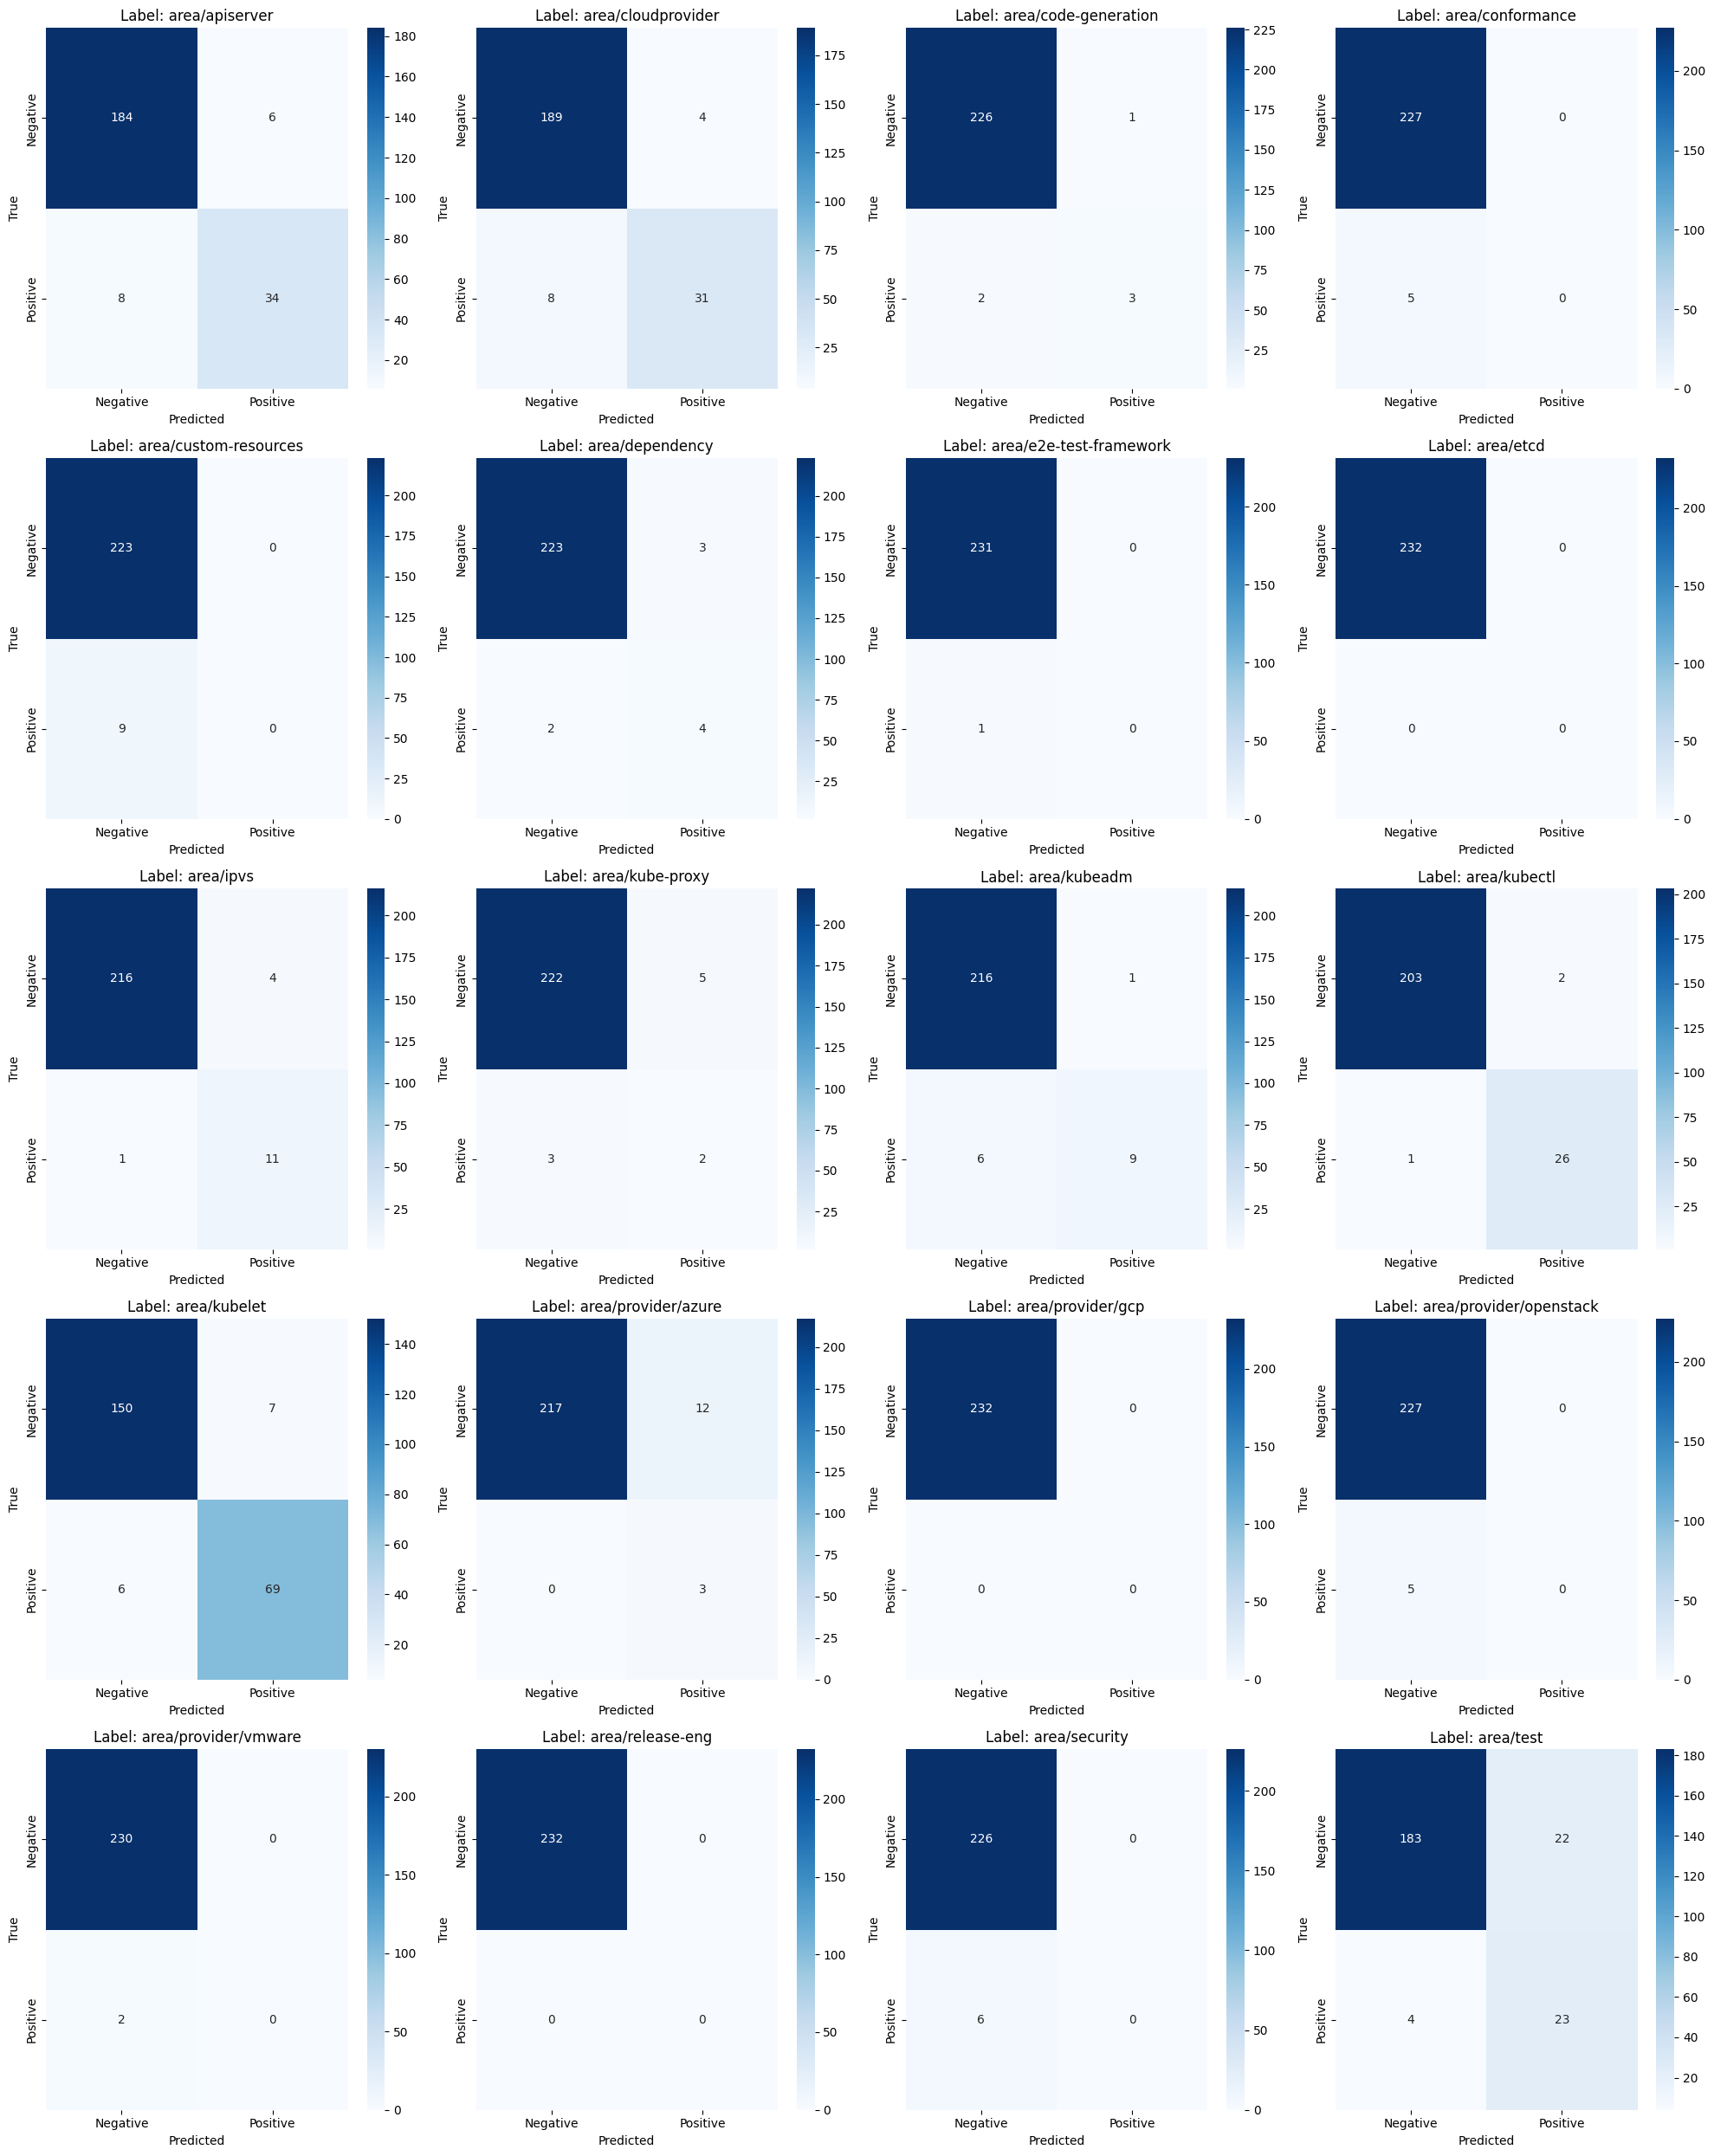

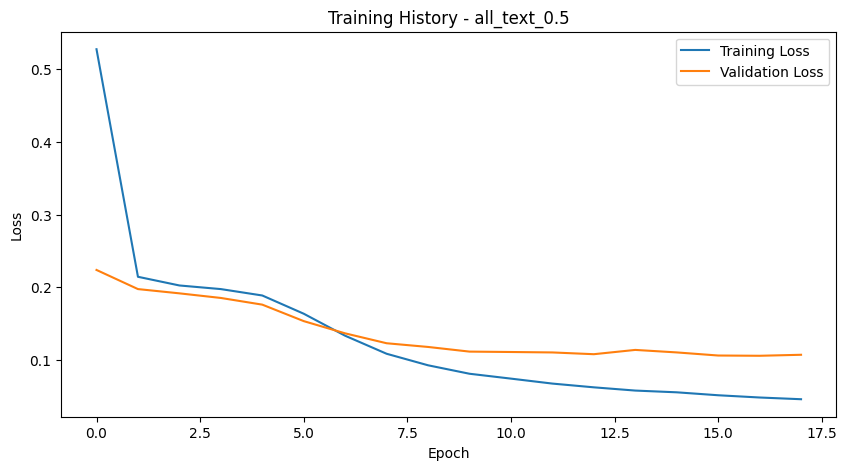

In [13]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## 2 SD

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 304.17it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 2.0 std dev threshold: (1.00, 1297.42)
Removed 36 samples (2.86% of data)

Token length statistics after filtering:
  Mean: 321.98, Std Dev: 249.30
  Min: 32, Max: 1281
  25th percentile: 147.00
  50th percentile (median): 237.00
  75th percentile: 402.75

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1222
Dataset size after basic cleaning: 1222 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Samples remaining after label filtering: 1207 (98.77% of data)

Step 5: Filtering infrequent label combinations (min frequency: 2)
Total unique label combinations before filtering: 109
Removed 57 infrequent label combinations 

Calculating token lengths: 100%|██████████| 1141/1141 [00:02<00:00, 431.56it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1275
Mean token length: 309.74
Median token length: 230.00
Encoding labels...
Label density: 0.0670
Average labels per sample: 1.34
Training samples: 912, Validation samples: 229
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.5154, Train Accuracy (Exact Match): 0.0263
Val Loss: 0.2204
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.77s/it]


Train Loss: 0.2133, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.1904
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.77s/it]


Train Loss: 0.2034, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1920
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.1984, Train Accuracy (Exact Match): 0.0055
Val Loss: 0.1927
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.1908, Train Accuracy (Exact Match): 0.0373
Val Loss: 0.1744
Val Accuracy (Exact Match): 0.0262
Val Accuracy (Partial Match): 0.0277
Val Accuracy (Jaccard): 0.0277
Val Precision: 0.0306, Val Recall: 0.0277, Val F1: 0.0284
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Train Loss: 0.1678, Train Accuracy (Exact Match): 0.1798
Val Loss: 0.1513
Val Accuracy (Exact Match): 0.2533
Val Accuracy (Partial Match): 0.3408
Val Accuracy (Jaccard): 0.3167
Val Precision: 0.3646, Val Recall: 0.3408, Val F1: 0.3390
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.1361, Train Accuracy (Exact Match): 0.3860
Val Loss: 0.1302
Val Accuracy (Exact Match): 0.3668
Val Accuracy (Partial Match): 0.4683
Val Accuracy (Jaccard): 0.4416
Val Precision: 0.4930, Val Recall: 0.4683, Val F1: 0.4666
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.1099, Train Accuracy (Exact Match): 0.5439
Val Loss: 0.1198
Val Accuracy (Exact Match): 0.4978
Val Accuracy (Partial Match): 0.6298
Val Accuracy (Jaccard): 0.5879
Val Precision: 0.6349, Val Recall: 0.6298, Val F1: 0.6185
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0917, Train Accuracy (Exact Match): 0.6425
Val Loss: 0.1109
Val Accuracy (Exact Match): 0.5415
Val Accuracy (Partial Match): 0.6787
Val Accuracy (Jaccard): 0.6368
Val Precision: 0.6873, Val Recall: 0.6787, Val F1: 0.6681
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0802, Train Accuracy (Exact Match): 0.6930
Val Loss: 0.1079
Val Accuracy (Exact Match): 0.5721
Val Accuracy (Partial Match): 0.7268
Val Accuracy (Jaccard): 0.6718
Val Precision: 0.7135, Val Recall: 0.7268, Val F1: 0.7052
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0718, Train Accuracy (Exact Match): 0.7182
Val Loss: 0.1048
Val Accuracy (Exact Match): 0.5502
Val Accuracy (Partial Match): 0.7231
Val Accuracy (Jaccard): 0.6608
Val Precision: 0.7092, Val Recall: 0.7231, Val F1: 0.6981

Epoch 12/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0664, Train Accuracy (Exact Match): 0.7577
Val Loss: 0.1042
Val Accuracy (Exact Match): 0.5764
Val Accuracy (Partial Match): 0.7661
Val Accuracy (Jaccard): 0.6972
Val Precision: 0.7463, Val Recall: 0.7661, Val F1: 0.7372
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0624, Train Accuracy (Exact Match): 0.7566
Val Loss: 0.0997
Val Accuracy (Exact Match): 0.5852
Val Accuracy (Partial Match): 0.7705
Val Accuracy (Jaccard): 0.7031
Val Precision: 0.7507, Val Recall: 0.7705, Val F1: 0.7416
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0589, Train Accuracy (Exact Match): 0.7577
Val Loss: 0.0977
Val Accuracy (Exact Match): 0.5852
Val Accuracy (Partial Match): 0.7508
Val Accuracy (Jaccard): 0.6951
Val Precision: 0.7463, Val Recall: 0.7508, Val F1: 0.7307

Epoch 15/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0549, Train Accuracy (Exact Match): 0.7851
Val Loss: 0.1017
Val Accuracy (Exact Match): 0.5939
Val Accuracy (Partial Match): 0.7443
Val Accuracy (Jaccard): 0.6936
Val Precision: 0.7397, Val Recall: 0.7443, Val F1: 0.7263

Epoch 16/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0530, Train Accuracy (Exact Match): 0.7862
Val Loss: 0.0992
Val Accuracy (Exact Match): 0.5895
Val Accuracy (Partial Match): 0.7617
Val Accuracy (Jaccard): 0.7009
Val Precision: 0.7485, Val Recall: 0.7617, Val F1: 0.7372

Epoch 17/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


Train Loss: 0.0490, Train Accuracy (Exact Match): 0.7993
Val Loss: 0.0983
Val Accuracy (Exact Match): 0.5764
Val Accuracy (Partial Match): 0.7668
Val Accuracy (Jaccard): 0.6965
Val Precision: 0.7463, Val Recall: 0.7668, Val F1: 0.7359

Epoch 18/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.77s/it]


Early stopping triggered
Train Loss: 0.0458, Train Accuracy (Exact Match): 0.8015
Val Loss: 0.0999
Val Accuracy (Exact Match): 0.5895
Val Accuracy (Partial Match): 0.7726
Val Accuracy (Jaccard): 0.7082
Val Precision: 0.7594, Val Recall: 0.7726, Val F1: 0.7474
Saved new best model to ./results/run_20250325_183244_all_text_0.5/best_model_all_text_0.5.pt
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


<ipython-input-12-74ef7e21d0bb>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5895
Partial Match Accuracy: 0.7726
Jaccard Similarity: 0.7082
Precision: 0.7594
Recall: 0.7726
F1 Score: 0.7474

Training completed! Results saved to ./results/run_20250325_183244_all_text_0.5


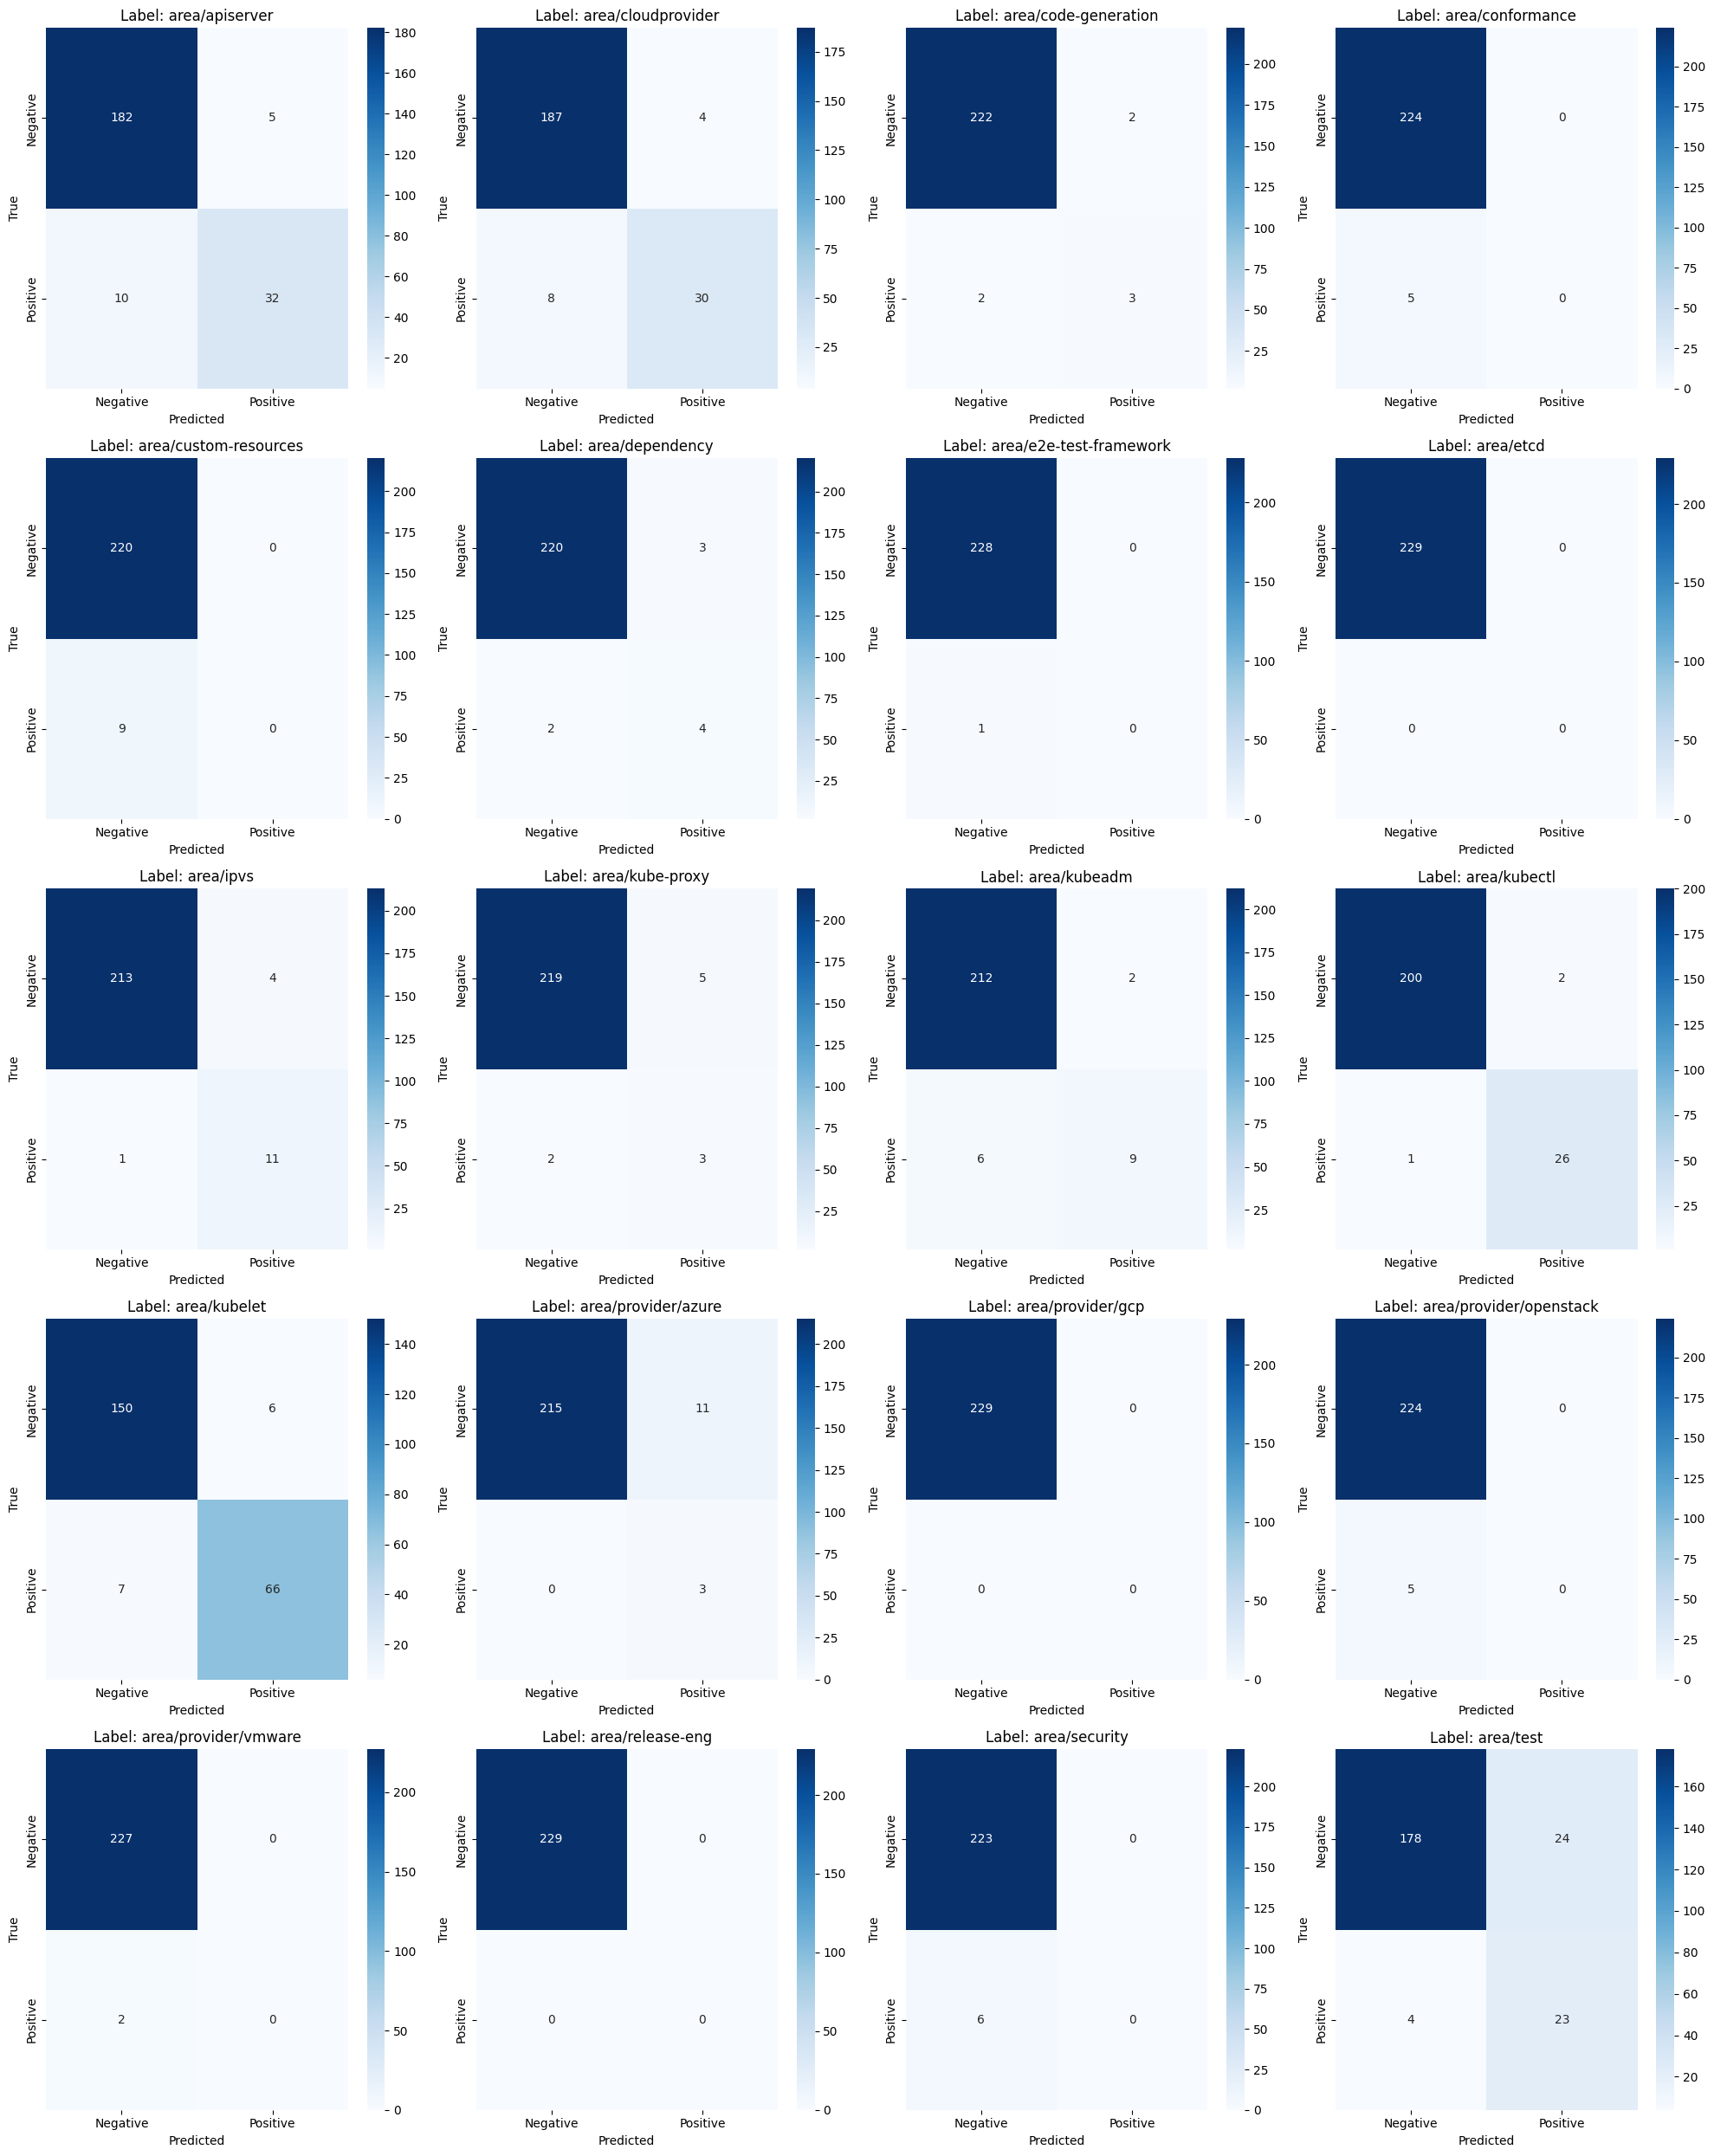

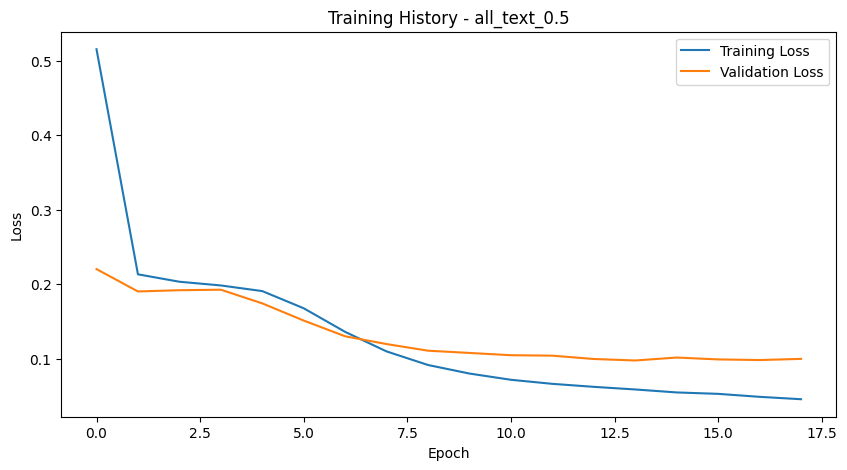

In [14]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='2std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# Filter By Minimum token threshold

## 50 tokens

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 295.96it/s]


Applying minimum token threshold of 50
Removed 3 samples below minimum token threshold
Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 24 samples (1.91% of data)

Token length statistics after filtering:
  Mean: 336.98, Std Dev: 279.65
  Min: 50, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 242.00
  75th percentile: 418.75

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1234
Dataset size after basic cleaning: 1234 (100.00% of original data)

Step 3: Filtering by token length...
Using minimum token threshold of 50


Calculating token lengths: 100%|██████████| 1234/1234 [00:03<00:00, 397.49it/s]


Applying minimum token threshold of 50
Removed 0 samples below minimum token threshold
Token length statistics before filtering:
  Mean: 336.98, Std Dev: 279.65
  Min: 50, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 242.00
  75th percentile: 418.75
Applied inf std dev threshold: (1.00, inf)
Removed 0 samples (0.00% of data)

Token length statistics after filtering:
  Mean: 336.98, Std Dev: 279.65
  Min: 50, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 242.00
  75th percentile: 418.75
Removed 0 samples by token length filtering (0.00% of data)
Texts after token length filtering: 1234 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Samples remaining after label filtering: 1219 (98.78% of data)

Step 5: Filtering infrequent label combinations (min frequency: 2)
Total unique label

Calculating token lengths: 100%|██████████| 1153/1153 [00:02<00:00, 385.09it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1725
Mean token length: 325.92
Median token length: 232.00
Encoding labels...
Label density: 0.0673
Average labels per sample: 1.35
Training samples: 922, Validation samples: 231
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 29/29 [00:53<00:00,  1.84s/it]


Train Loss: 0.5054, Train Accuracy (Exact Match): 0.0217
Val Loss: 0.2214
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Train Loss: 0.2126, Train Accuracy (Exact Match): 0.0022
Val Loss: 0.1965
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.79s/it]


Train Loss: 0.2012, Train Accuracy (Exact Match): 0.0022
Val Loss: 0.1922
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 29/29 [00:51<00:00,  1.79s/it]


Train Loss: 0.1964, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.1880
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.1881, Train Accuracy (Exact Match): 0.0380
Val Loss: 0.1780
Val Accuracy (Exact Match): 0.0736
Val Accuracy (Partial Match): 0.0750
Val Accuracy (Jaccard): 0.0750
Val Precision: 0.0779, Val Recall: 0.0750, Val F1: 0.0758
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.1622, Train Accuracy (Exact Match): 0.2343
Val Loss: 0.1569
Val Accuracy (Exact Match): 0.2597
Val Accuracy (Partial Match): 0.3538
Val Accuracy (Jaccard): 0.3278
Val Precision: 0.3766, Val Recall: 0.3538, Val F1: 0.3515
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.1319, Train Accuracy (Exact Match): 0.4121
Val Loss: 0.1372
Val Accuracy (Exact Match): 0.3810
Val Accuracy (Partial Match): 0.5120
Val Accuracy (Jaccard): 0.4690
Val Precision: 0.5151, Val Recall: 0.5120, Val F1: 0.4992
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.1072, Train Accuracy (Exact Match): 0.5499
Val Loss: 0.1267
Val Accuracy (Exact Match): 0.4545
Val Accuracy (Partial Match): 0.5863
Val Accuracy (Jaccard): 0.5426
Val Precision: 0.5840, Val Recall: 0.5863, Val F1: 0.5721
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 29/29 [00:53<00:00,  1.83s/it]


Train Loss: 0.0909, Train Accuracy (Exact Match): 0.6410
Val Loss: 0.1194
Val Accuracy (Exact Match): 0.5281
Val Accuracy (Partial Match): 0.6772
Val Accuracy (Jaccard): 0.6277
Val Precision: 0.6749, Val Recall: 0.6772, Val F1: 0.6608
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0797, Train Accuracy (Exact Match): 0.6800
Val Loss: 0.1190
Val Accuracy (Exact Match): 0.5368
Val Accuracy (Partial Match): 0.7183
Val Accuracy (Jaccard): 0.6537
Val Precision: 0.7030, Val Recall: 0.7183, Val F1: 0.6926
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0726, Train Accuracy (Exact Match): 0.7082
Val Loss: 0.1129
Val Accuracy (Exact Match): 0.5455
Val Accuracy (Partial Match): 0.7378
Val Accuracy (Jaccard): 0.6681
Val Precision: 0.7182, Val Recall: 0.7378, Val F1: 0.7085
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Train Loss: 0.0670, Train Accuracy (Exact Match): 0.7375
Val Loss: 0.1136
Val Accuracy (Exact Match): 0.5628
Val Accuracy (Partial Match): 0.7681
Val Accuracy (Jaccard): 0.6912
Val Precision: 0.7398, Val Recall: 0.7681, Val F1: 0.7337
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0617, Train Accuracy (Exact Match): 0.7505
Val Loss: 0.1116
Val Accuracy (Exact Match): 0.5498
Val Accuracy (Partial Match): 0.7724
Val Accuracy (Jaccard): 0.6890
Val Precision: 0.7420, Val Recall: 0.7724, Val F1: 0.7344
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0576, Train Accuracy (Exact Match): 0.7711
Val Loss: 0.1128
Val Accuracy (Exact Match): 0.5887
Val Accuracy (Partial Match): 0.7638
Val Accuracy (Jaccard): 0.6999
Val Precision: 0.7442, Val Recall: 0.7638, Val F1: 0.7366
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Train Loss: 0.0543, Train Accuracy (Exact Match): 0.7874
Val Loss: 0.1113
Val Accuracy (Exact Match): 0.5628
Val Accuracy (Partial Match): 0.7584
Val Accuracy (Jaccard): 0.6867
Val Precision: 0.7359, Val Recall: 0.7584, Val F1: 0.7278

Epoch 16/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it]


Train Loss: 0.0506, Train Accuracy (Exact Match): 0.8004
Val Loss: 0.1118
Val Accuracy (Exact Match): 0.5628
Val Accuracy (Partial Match): 0.7605
Val Accuracy (Jaccard): 0.6867
Val Precision: 0.7353, Val Recall: 0.7605, Val F1: 0.7281

Epoch 17/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.81s/it]


Train Loss: 0.0478, Train Accuracy (Exact Match): 0.8037
Val Loss: 0.1118
Val Accuracy (Exact Match): 0.5758
Val Accuracy (Partial Match): 0.7735
Val Accuracy (Jaccard): 0.6983
Val Precision: 0.7439, Val Recall: 0.7735, Val F1: 0.7396
Saved new best model to ./results/run_20250325_185154_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 29/29 [00:52<00:00,  1.82s/it]


Early stopping triggered
Train Loss: 0.0454, Train Accuracy (Exact Match): 0.8145
Val Loss: 0.1092
Val Accuracy (Exact Match): 0.5758
Val Accuracy (Partial Match): 0.7616
Val Accuracy (Jaccard): 0.6977
Val Precision: 0.7528, Val Recall: 0.7616, Val F1: 0.7373
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


<ipython-input-12-74ef7e21d0bb>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5758
Partial Match Accuracy: 0.7735
Jaccard Similarity: 0.6983
Precision: 0.7439
Recall: 0.7735
F1 Score: 0.7396

Training completed! Results saved to ./results/run_20250325_185154_all_text_0.5


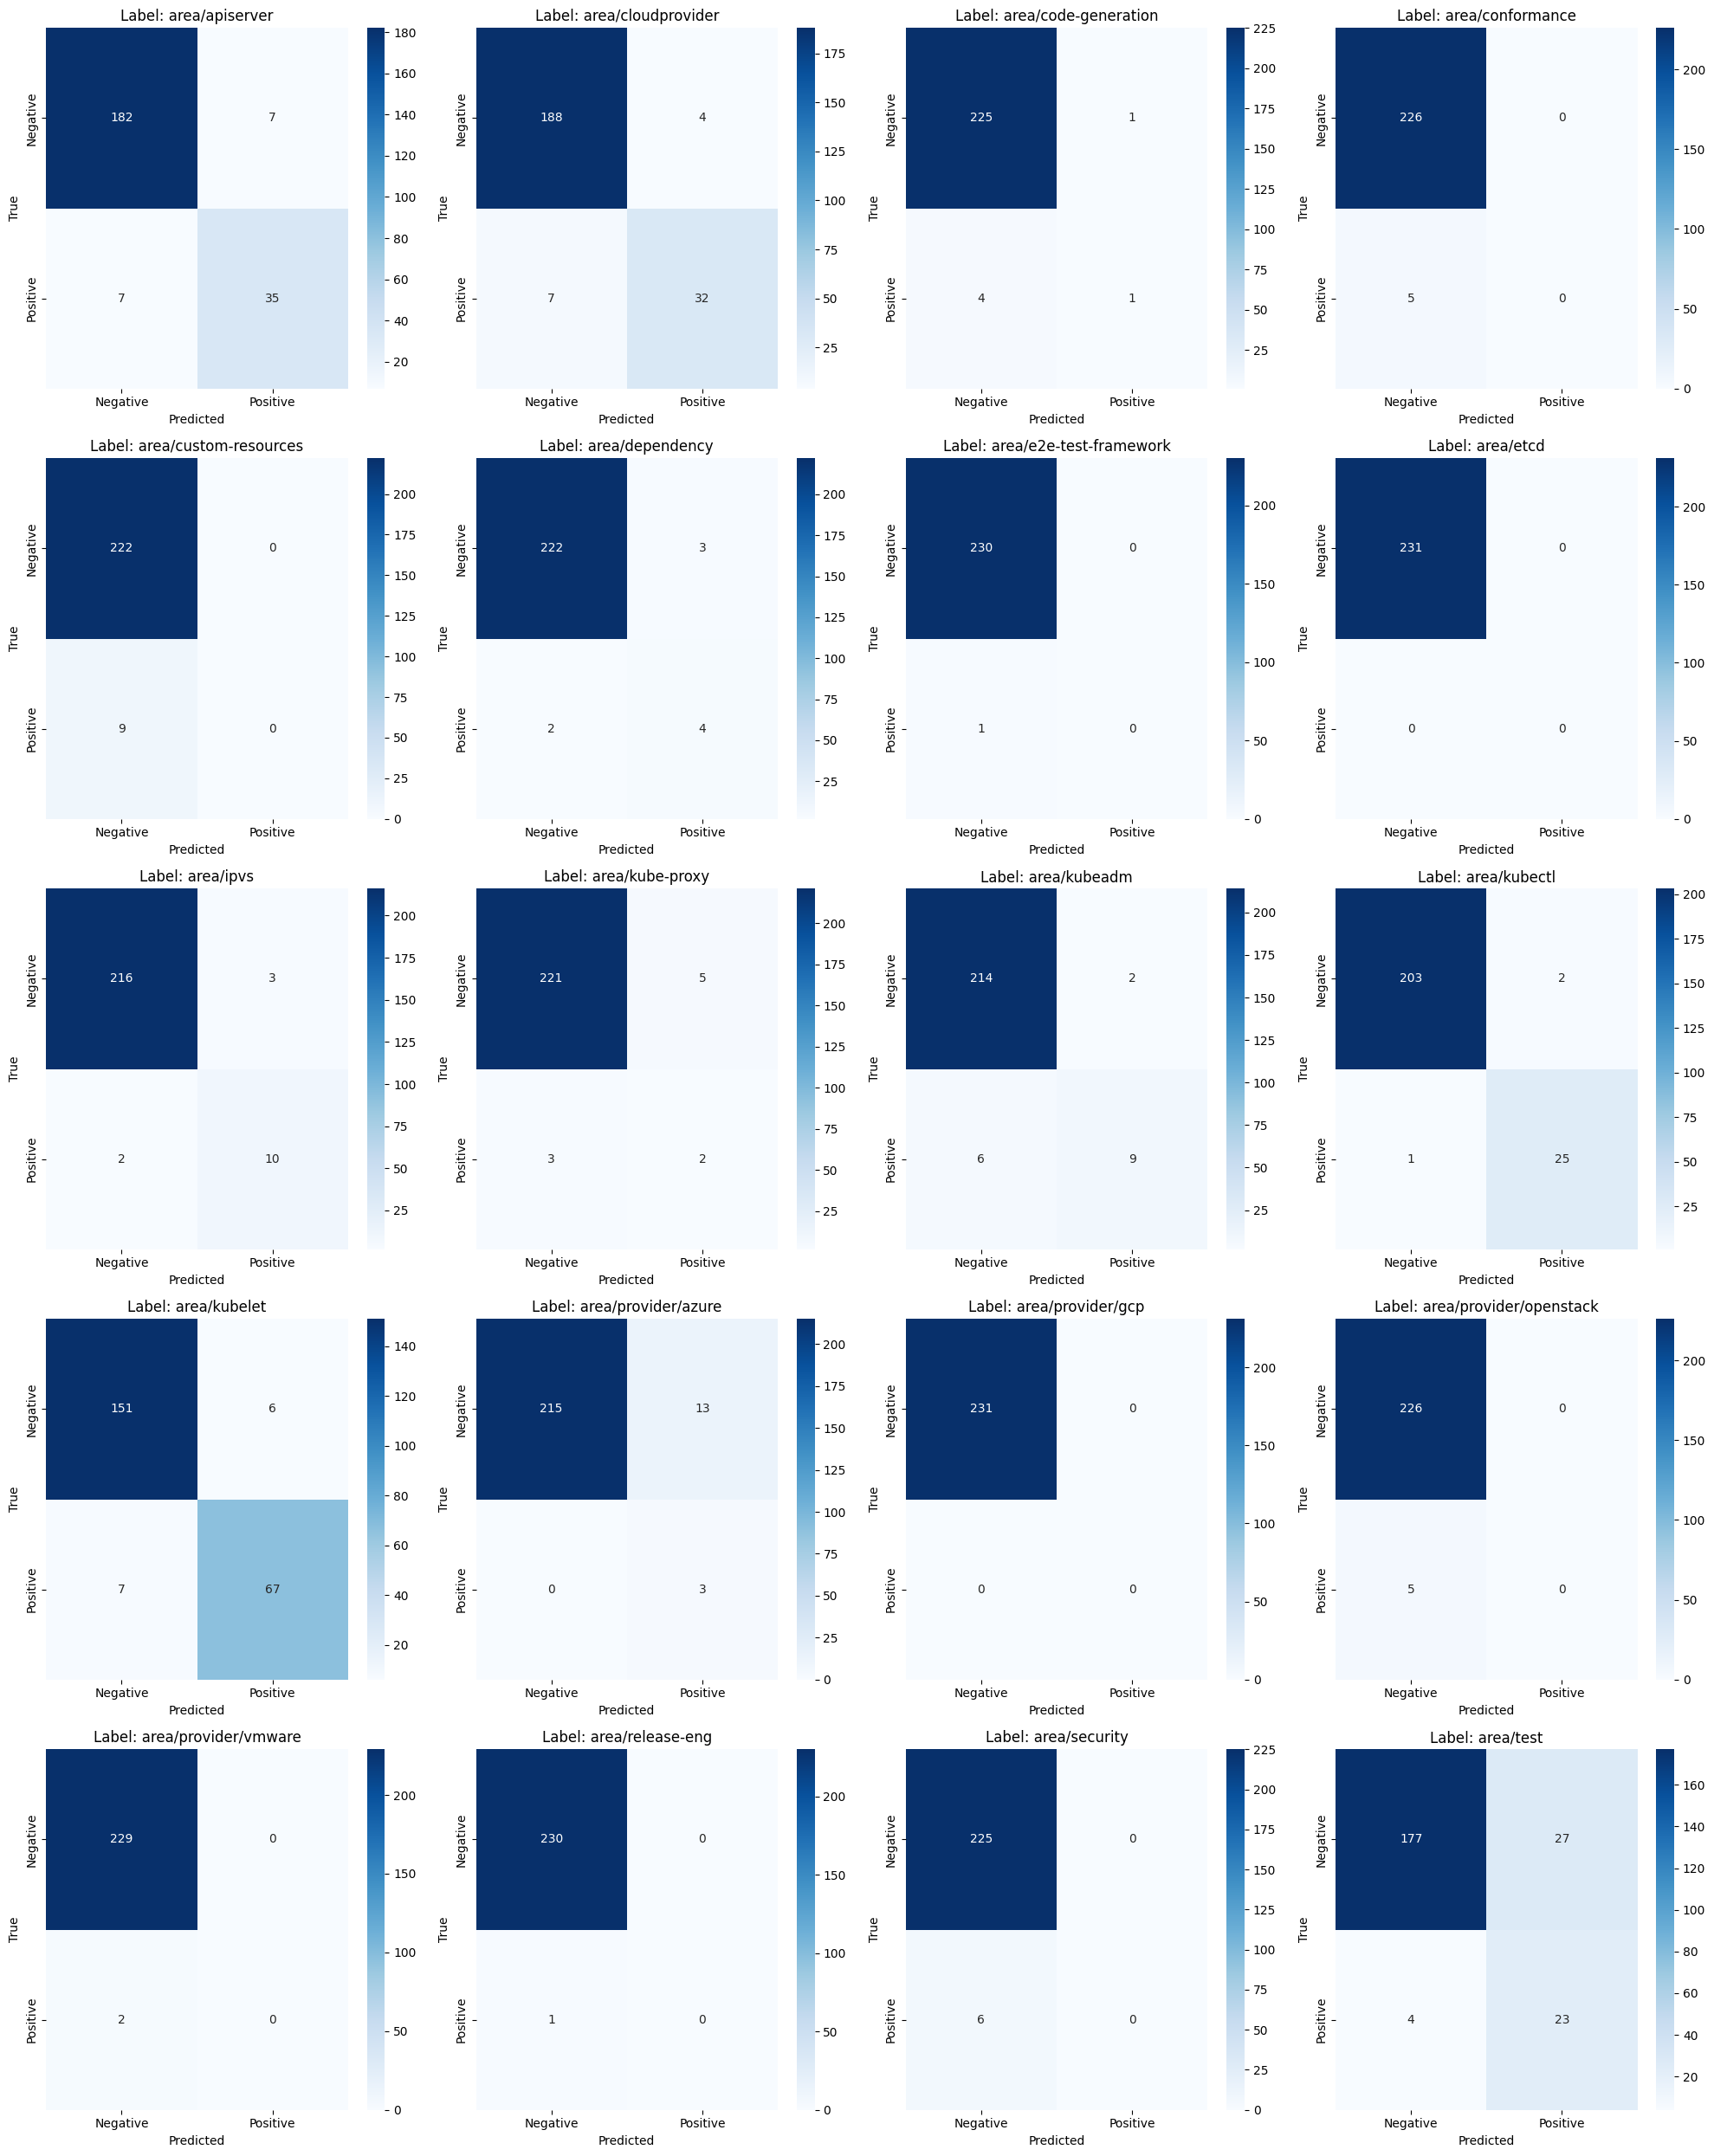

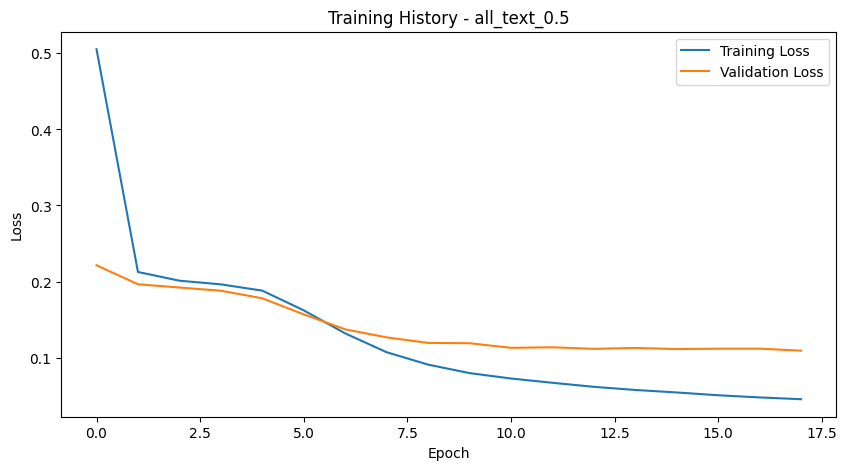

In [15]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=50,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## 75 tokens

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 300.57it/s]


Applying minimum token threshold of 75
Removed 51 samples below minimum token threshold
Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 72 samples (5.72% of data)

Token length statistics after filtering:
  Mean: 348.06, Std Dev: 279.66
  Min: 75, Max: 1725
  25th percentile: 155.25
  50th percentile (median): 252.00
  75th percentile: 435.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1186
Dataset size after basic cleaning: 1186 (100.00% of original data)

Step 3: Filtering by token length...
Using minimum token threshold of 75


Calculating token lengths: 100%|██████████| 1186/1186 [00:03<00:00, 383.69it/s]


Applying minimum token threshold of 75
Removed 0 samples below minimum token threshold
Token length statistics before filtering:
  Mean: 348.06, Std Dev: 279.66
  Min: 75, Max: 1725
  25th percentile: 155.25
  50th percentile (median): 252.00
  75th percentile: 435.00
Applied inf std dev threshold: (1.00, inf)
Removed 0 samples (0.00% of data)

Token length statistics after filtering:
  Mean: 348.06, Std Dev: 279.66
  Min: 75, Max: 1725
  25th percentile: 155.25
  50th percentile (median): 252.00
  75th percentile: 435.00
Removed 0 samples by token length filtering (0.00% of data)
Texts after token length filtering: 1186 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Samples remaining after label filtering: 1171 (98.74% of data)

Step 5: Filtering infrequent label combinations (min frequency: 2)
Total unique label

Calculating token lengths: 100%|██████████| 1105/1105 [00:02<00:00, 375.04it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1725
Mean token length: 337.33
Median token length: 244.00
Encoding labels...
Label density: 0.0679
Average labels per sample: 1.36
Training samples: 884, Validation samples: 221
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]


Train Loss: 0.5206, Train Accuracy (Exact Match): 0.0136
Val Loss: 0.2275
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


Train Loss: 0.2167, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1959
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 28/28 [00:49<00:00,  1.78s/it]


Train Loss: 0.2009, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.1950
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.1970, Train Accuracy (Exact Match): 0.0045
Val Loss: 0.1913
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.1902, Train Accuracy (Exact Match): 0.0181
Val Loss: 0.1784
Val Accuracy (Exact Match): 0.1267
Val Accuracy (Partial Match): 0.1305
Val Accuracy (Jaccard): 0.1305
Val Precision: 0.1357, Val Recall: 0.1305, Val F1: 0.1320
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.1623, Train Accuracy (Exact Match): 0.2330
Val Loss: 0.1557
Val Accuracy (Exact Match): 0.2715
Val Accuracy (Partial Match): 0.3646
Val Accuracy (Jaccard): 0.3362
Val Precision: 0.3771, Val Recall: 0.3646, Val F1: 0.3587
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


Train Loss: 0.1329, Train Accuracy (Exact Match): 0.4186
Val Loss: 0.1400
Val Accuracy (Exact Match): 0.3756
Val Accuracy (Partial Match): 0.4967
Val Accuracy (Jaccard): 0.4578
Val Precision: 0.5041, Val Recall: 0.4967, Val F1: 0.4859
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.1114, Train Accuracy (Exact Match): 0.5475
Val Loss: 0.1251
Val Accuracy (Exact Match): 0.4480
Val Accuracy (Partial Match): 0.5811
Val Accuracy (Jaccard): 0.5354
Val Precision: 0.5742, Val Recall: 0.5811, Val F1: 0.5648
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0968, Train Accuracy (Exact Match): 0.6290
Val Loss: 0.1219
Val Accuracy (Exact Match): 0.5249
Val Accuracy (Partial Match): 0.6671
Val Accuracy (Jaccard): 0.6199
Val Precision: 0.6647, Val Recall: 0.6671, Val F1: 0.6515
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0820, Train Accuracy (Exact Match): 0.6833
Val Loss: 0.1209
Val Accuracy (Exact Match): 0.5339
Val Accuracy (Partial Match): 0.7124
Val Accuracy (Jaccard): 0.6486
Val Precision: 0.6964, Val Recall: 0.7124, Val F1: 0.6870
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.82s/it]


Train Loss: 0.0764, Train Accuracy (Exact Match): 0.7059
Val Loss: 0.1137
Val Accuracy (Exact Match): 0.5520
Val Accuracy (Partial Match): 0.7305
Val Accuracy (Jaccard): 0.6682
Val Precision: 0.7190, Val Recall: 0.7305, Val F1: 0.7058
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


Train Loss: 0.0691, Train Accuracy (Exact Match): 0.7308
Val Loss: 0.1156
Val Accuracy (Exact Match): 0.5385
Val Accuracy (Partial Match): 0.7440
Val Accuracy (Jaccard): 0.6674
Val Precision: 0.7167, Val Recall: 0.7440, Val F1: 0.7096
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0639, Train Accuracy (Exact Match): 0.7353
Val Loss: 0.1167
Val Accuracy (Exact Match): 0.5520
Val Accuracy (Partial Match): 0.7599
Val Accuracy (Jaccard): 0.6802
Val Precision: 0.7258, Val Recall: 0.7599, Val F1: 0.7232
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0596, Train Accuracy (Exact Match): 0.7692
Val Loss: 0.1103
Val Accuracy (Exact Match): 0.5520
Val Accuracy (Partial Match): 0.7452
Val Accuracy (Jaccard): 0.6756
Val Precision: 0.7278, Val Recall: 0.7452, Val F1: 0.7165

Epoch 15/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0561, Train Accuracy (Exact Match): 0.7602
Val Loss: 0.1126
Val Accuracy (Exact Match): 0.5656
Val Accuracy (Partial Match): 0.7780
Val Accuracy (Jaccard): 0.6946
Val Precision: 0.7371, Val Recall: 0.7780, Val F1: 0.7368
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


Train Loss: 0.0526, Train Accuracy (Exact Match): 0.7794
Val Loss: 0.1134
Val Accuracy (Exact Match): 0.5701
Val Accuracy (Partial Match): 0.7746
Val Accuracy (Jaccard): 0.6952
Val Precision: 0.7391, Val Recall: 0.7746, Val F1: 0.7369
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


Train Loss: 0.0485, Train Accuracy (Exact Match): 0.7986
Val Loss: 0.1116
Val Accuracy (Exact Match): 0.5656
Val Accuracy (Partial Match): 0.7825
Val Accuracy (Jaccard): 0.6991
Val Precision: 0.7462, Val Recall: 0.7825, Val F1: 0.7428
Saved new best model to ./results/run_20250325_191127_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0458, Train Accuracy (Exact Match): 0.8077
Val Loss: 0.1131
Val Accuracy (Exact Match): 0.5837
Val Accuracy (Partial Match): 0.7712
Val Accuracy (Jaccard): 0.7036
Val Precision: 0.7529, Val Recall: 0.7712, Val F1: 0.7428

Epoch 19/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Train Loss: 0.0448, Train Accuracy (Exact Match): 0.8179
Val Loss: 0.1105
Val Accuracy (Exact Match): 0.5701
Val Accuracy (Partial Match): 0.7689
Val Accuracy (Jaccard): 0.6961
Val Precision: 0.7462, Val Recall: 0.7689, Val F1: 0.7375

Epoch 20/20


Training: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]


Train Loss: 0.0416, Train Accuracy (Exact Match): 0.8281
Val Loss: 0.1141
Val Accuracy (Exact Match): 0.5747
Val Accuracy (Partial Match): 0.7554
Val Accuracy (Jaccard): 0.6878
Val Precision: 0.7303, Val Recall: 0.7554, Val F1: 0.7247

Loading best model for final evaluation...


<ipython-input-12-74ef7e21d0bb>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5656
Partial Match Accuracy: 0.7825
Jaccard Similarity: 0.6991
Precision: 0.7462
Recall: 0.7825
F1 Score: 0.7428

Training completed! Results saved to ./results/run_20250325_191127_all_text_0.5


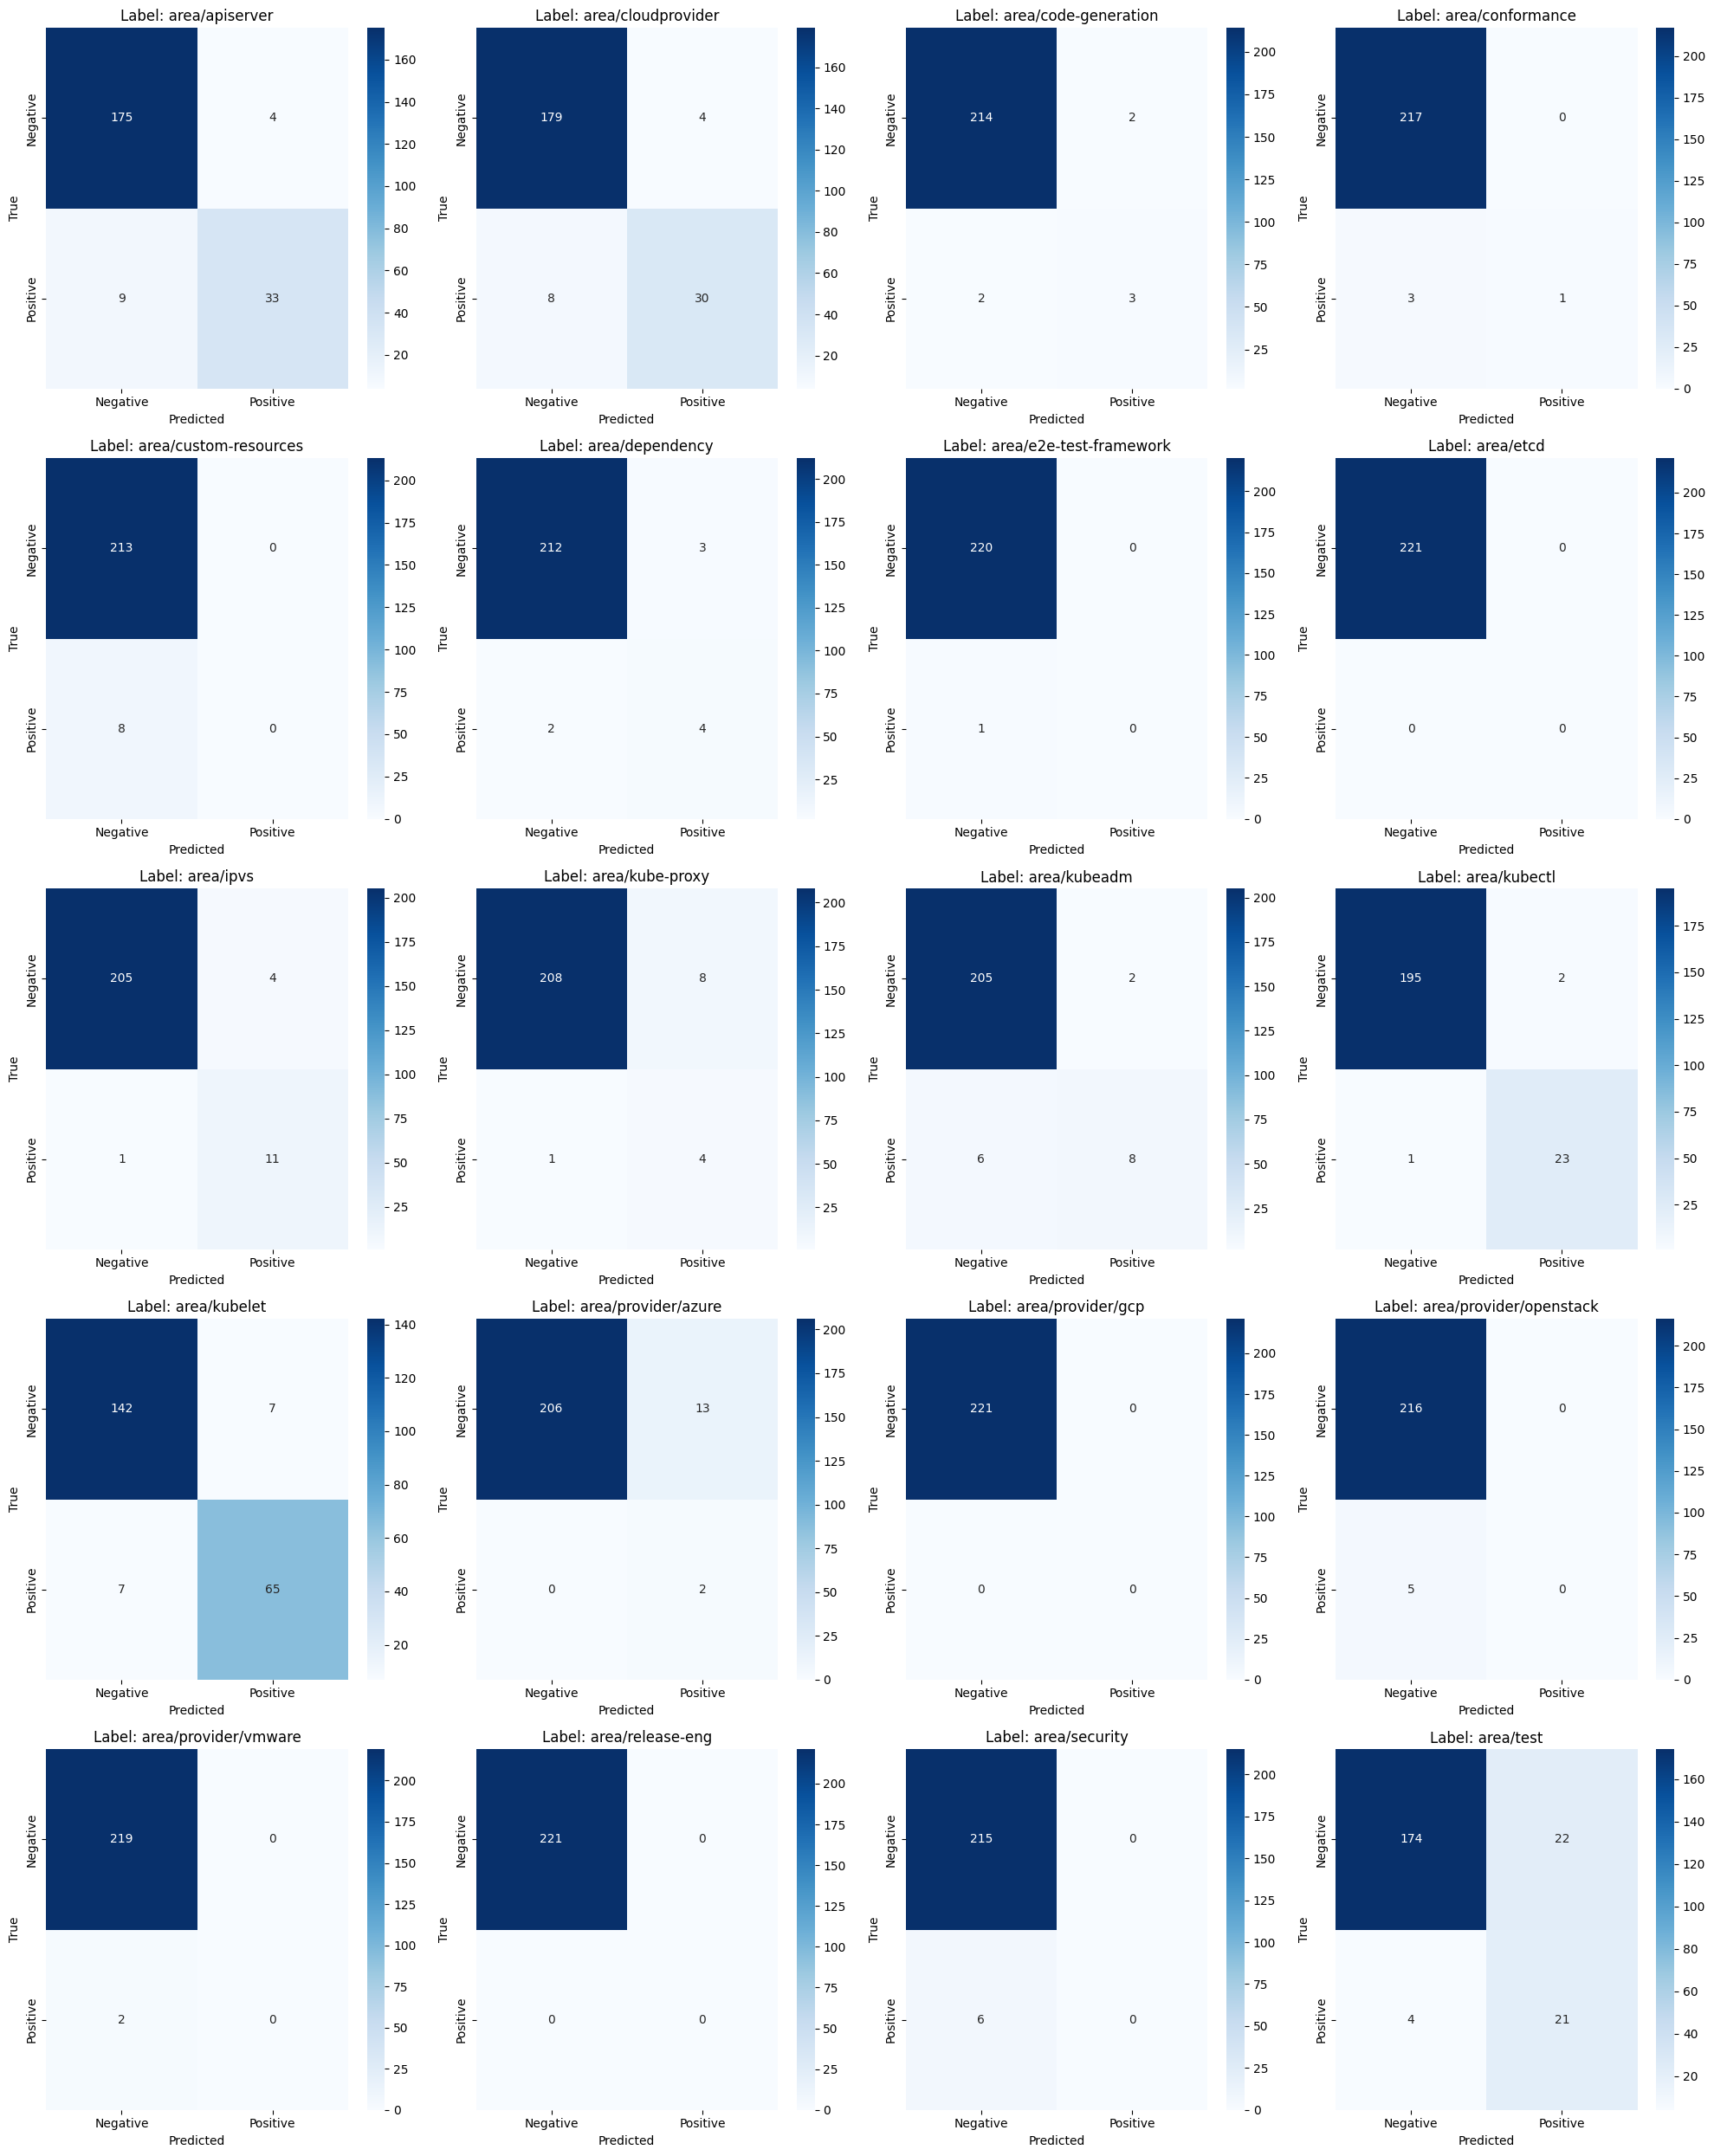

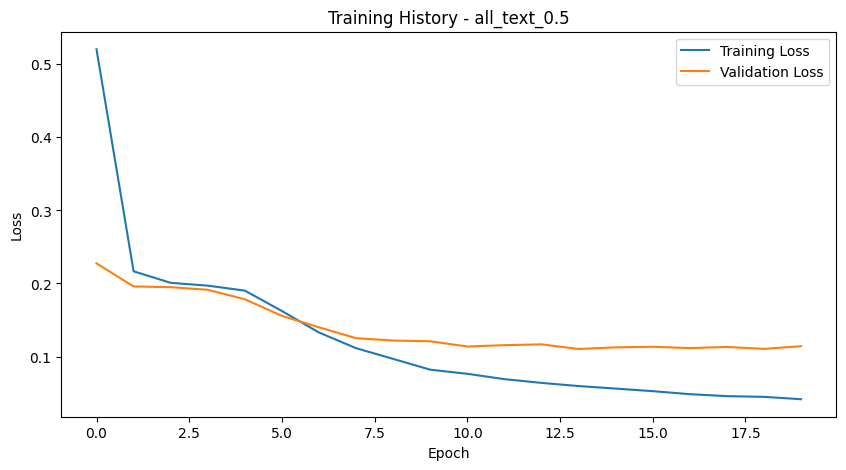

In [16]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=75,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## 100 tokens

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 287.09it/s]


Applying minimum token threshold of 100
Removed 124 samples below minimum token threshold
Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 145 samples (11.53% of data)

Token length statistics after filtering:
  Mean: 365.03, Std Dev: 280.46
  Min: 100, Max: 1725
  25th percentile: 172.00
  50th percentile (median): 269.00
  75th percentile: 453.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1113
Dataset size after basic cleaning: 1113 (100.00% of original data)

Step 3: Filtering by token length...
Using minimum token threshold of 100


Calculating token lengths: 100%|██████████| 1113/1113 [00:03<00:00, 357.98it/s]


Applying minimum token threshold of 100
Removed 0 samples below minimum token threshold
Token length statistics before filtering:
  Mean: 365.03, Std Dev: 280.46
  Min: 100, Max: 1725
  25th percentile: 172.00
  50th percentile (median): 269.00
  75th percentile: 453.00
Applied inf std dev threshold: (1.00, inf)
Removed 0 samples (0.00% of data)

Token length statistics after filtering:
  Mean: 365.03, Std Dev: 280.46
  Min: 100, Max: 1725
  25th percentile: 172.00
  50th percentile (median): 269.00
  75th percentile: 453.00
Removed 0 samples by token length filtering (0.00% of data)
Texts after token length filtering: 1113 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 36
Removed 16 infrequent labels (44.44% of labels)
Number of labels remaining: 20 (55.56% of labels)
Samples remaining after label filtering: 1101 (98.92% of data)

Step 5: Filtering infrequent label combinations (min frequency: 2)
Total unique la

Calculating token lengths: 100%|██████████| 1036/1036 [00:02<00:00, 354.71it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1725
Mean token length: 353.85
Median token length: 260.00
Encoding labels...
Label density: 0.0688
Average labels per sample: 1.38
Training samples: 828, Validation samples: 208
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 26/26 [00:48<00:00,  1.86s/it]


Train Loss: 0.5386, Train Accuracy (Exact Match): 0.0181
Val Loss: 0.2433
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.2237, Train Accuracy (Exact Match): 0.0012
Val Loss: 0.1988
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.2047, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1996
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.2003, Train Accuracy (Exact Match): 0.0060
Val Loss: 0.1930
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.1959, Train Accuracy (Exact Match): 0.0109
Val Loss: 0.1863
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.1810, Train Accuracy (Exact Match): 0.1087
Val Loss: 0.1688
Val Accuracy (Exact Match): 0.2115
Val Accuracy (Partial Match): 0.2300
Val Accuracy (Jaccard): 0.2276
Val Precision: 0.2428, Val Recall: 0.2300, Val F1: 0.2332
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.1524, Train Accuracy (Exact Match): 0.2995
Val Loss: 0.1479
Val Accuracy (Exact Match): 0.3029
Val Accuracy (Partial Match): 0.4046
Val Accuracy (Jaccard): 0.3746
Val Precision: 0.4191, Val Recall: 0.4046, Val F1: 0.3991
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.1276, Train Accuracy (Exact Match): 0.4408
Val Loss: 0.1365
Val Accuracy (Exact Match): 0.3750
Val Accuracy (Partial Match): 0.5212
Val Accuracy (Jaccard): 0.4726
Val Precision: 0.5188, Val Recall: 0.5212, Val F1: 0.5053
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.1071, Train Accuracy (Exact Match): 0.5713
Val Loss: 0.1307
Val Accuracy (Exact Match): 0.4423
Val Accuracy (Partial Match): 0.5886
Val Accuracy (Jaccard): 0.5409
Val Precision: 0.5885, Val Recall: 0.5886, Val F1: 0.5737
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.0917, Train Accuracy (Exact Match): 0.6461
Val Loss: 0.1226
Val Accuracy (Exact Match): 0.5192
Val Accuracy (Partial Match): 0.6655
Val Accuracy (Jaccard): 0.6218
Val Precision: 0.6774, Val Recall: 0.6655, Val F1: 0.6554
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.0835, Train Accuracy (Exact Match): 0.6594
Val Loss: 0.1251
Val Accuracy (Exact Match): 0.5433
Val Accuracy (Partial Match): 0.7096
Val Accuracy (Jaccard): 0.6538
Val Precision: 0.7038, Val Recall: 0.7096, Val F1: 0.6905
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.83s/it]


Train Loss: 0.0766, Train Accuracy (Exact Match): 0.6957
Val Loss: 0.1209
Val Accuracy (Exact Match): 0.5240
Val Accuracy (Partial Match): 0.7304
Val Accuracy (Jaccard): 0.6546
Val Precision: 0.7063, Val Recall: 0.7304, Val F1: 0.6979
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.0697, Train Accuracy (Exact Match): 0.7101
Val Loss: 0.1175
Val Accuracy (Exact Match): 0.5337
Val Accuracy (Partial Match): 0.7329
Val Accuracy (Jaccard): 0.6619
Val Precision: 0.7159, Val Recall: 0.7329, Val F1: 0.7035
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.81s/it]


Train Loss: 0.0647, Train Accuracy (Exact Match): 0.7295
Val Loss: 0.1158
Val Accuracy (Exact Match): 0.5288
Val Accuracy (Partial Match): 0.7353
Val Accuracy (Jaccard): 0.6579
Val Precision: 0.7063, Val Recall: 0.7353, Val F1: 0.7003

Epoch 15/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.0610, Train Accuracy (Exact Match): 0.7391
Val Loss: 0.1153
Val Accuracy (Exact Match): 0.5625
Val Accuracy (Partial Match): 0.7617
Val Accuracy (Jaccard): 0.6915
Val Precision: 0.7471, Val Recall: 0.7617, Val F1: 0.7331
Saved new best model to ./results/run_20250325_193213_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.0576, Train Accuracy (Exact Match): 0.7572
Val Loss: 0.1139
Val Accuracy (Exact Match): 0.5481
Val Accuracy (Partial Match): 0.7617
Val Accuracy (Jaccard): 0.6851
Val Precision: 0.7423, Val Recall: 0.7617, Val F1: 0.7299

Epoch 17/20


Training: 100%|██████████| 26/26 [00:46<00:00,  1.81s/it]


Train Loss: 0.0532, Train Accuracy (Exact Match): 0.7766
Val Loss: 0.1168
Val Accuracy (Exact Match): 0.5433
Val Accuracy (Partial Match): 0.7617
Val Accuracy (Jaccard): 0.6819
Val Precision: 0.7375, Val Recall: 0.7617, Val F1: 0.7267

Epoch 18/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.83s/it]


Train Loss: 0.0498, Train Accuracy (Exact Match): 0.7886
Val Loss: 0.1143
Val Accuracy (Exact Match): 0.5529
Val Accuracy (Partial Match): 0.7473
Val Accuracy (Jaccard): 0.6771
Val Precision: 0.7279, Val Recall: 0.7473, Val F1: 0.7179

Epoch 19/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Train Loss: 0.0475, Train Accuracy (Exact Match): 0.7995
Val Loss: 0.1155
Val Accuracy (Exact Match): 0.5385
Val Accuracy (Partial Match): 0.7593
Val Accuracy (Jaccard): 0.6787
Val Precision: 0.7351, Val Recall: 0.7593, Val F1: 0.7243

Epoch 20/20


Training: 100%|██████████| 26/26 [00:47<00:00,  1.82s/it]


Early stopping triggered
Train Loss: 0.0453, Train Accuracy (Exact Match): 0.7983
Val Loss: 0.1134
Val Accuracy (Exact Match): 0.5433
Val Accuracy (Partial Match): 0.7641
Val Accuracy (Jaccard): 0.6827
Val Precision: 0.7375, Val Recall: 0.7641, Val F1: 0.7283
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


<ipython-input-12-74ef7e21d0bb>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5625
Partial Match Accuracy: 0.7617
Jaccard Similarity: 0.6915
Precision: 0.7471
Recall: 0.7617
F1 Score: 0.7331

Training completed! Results saved to ./results/run_20250325_193213_all_text_0.5


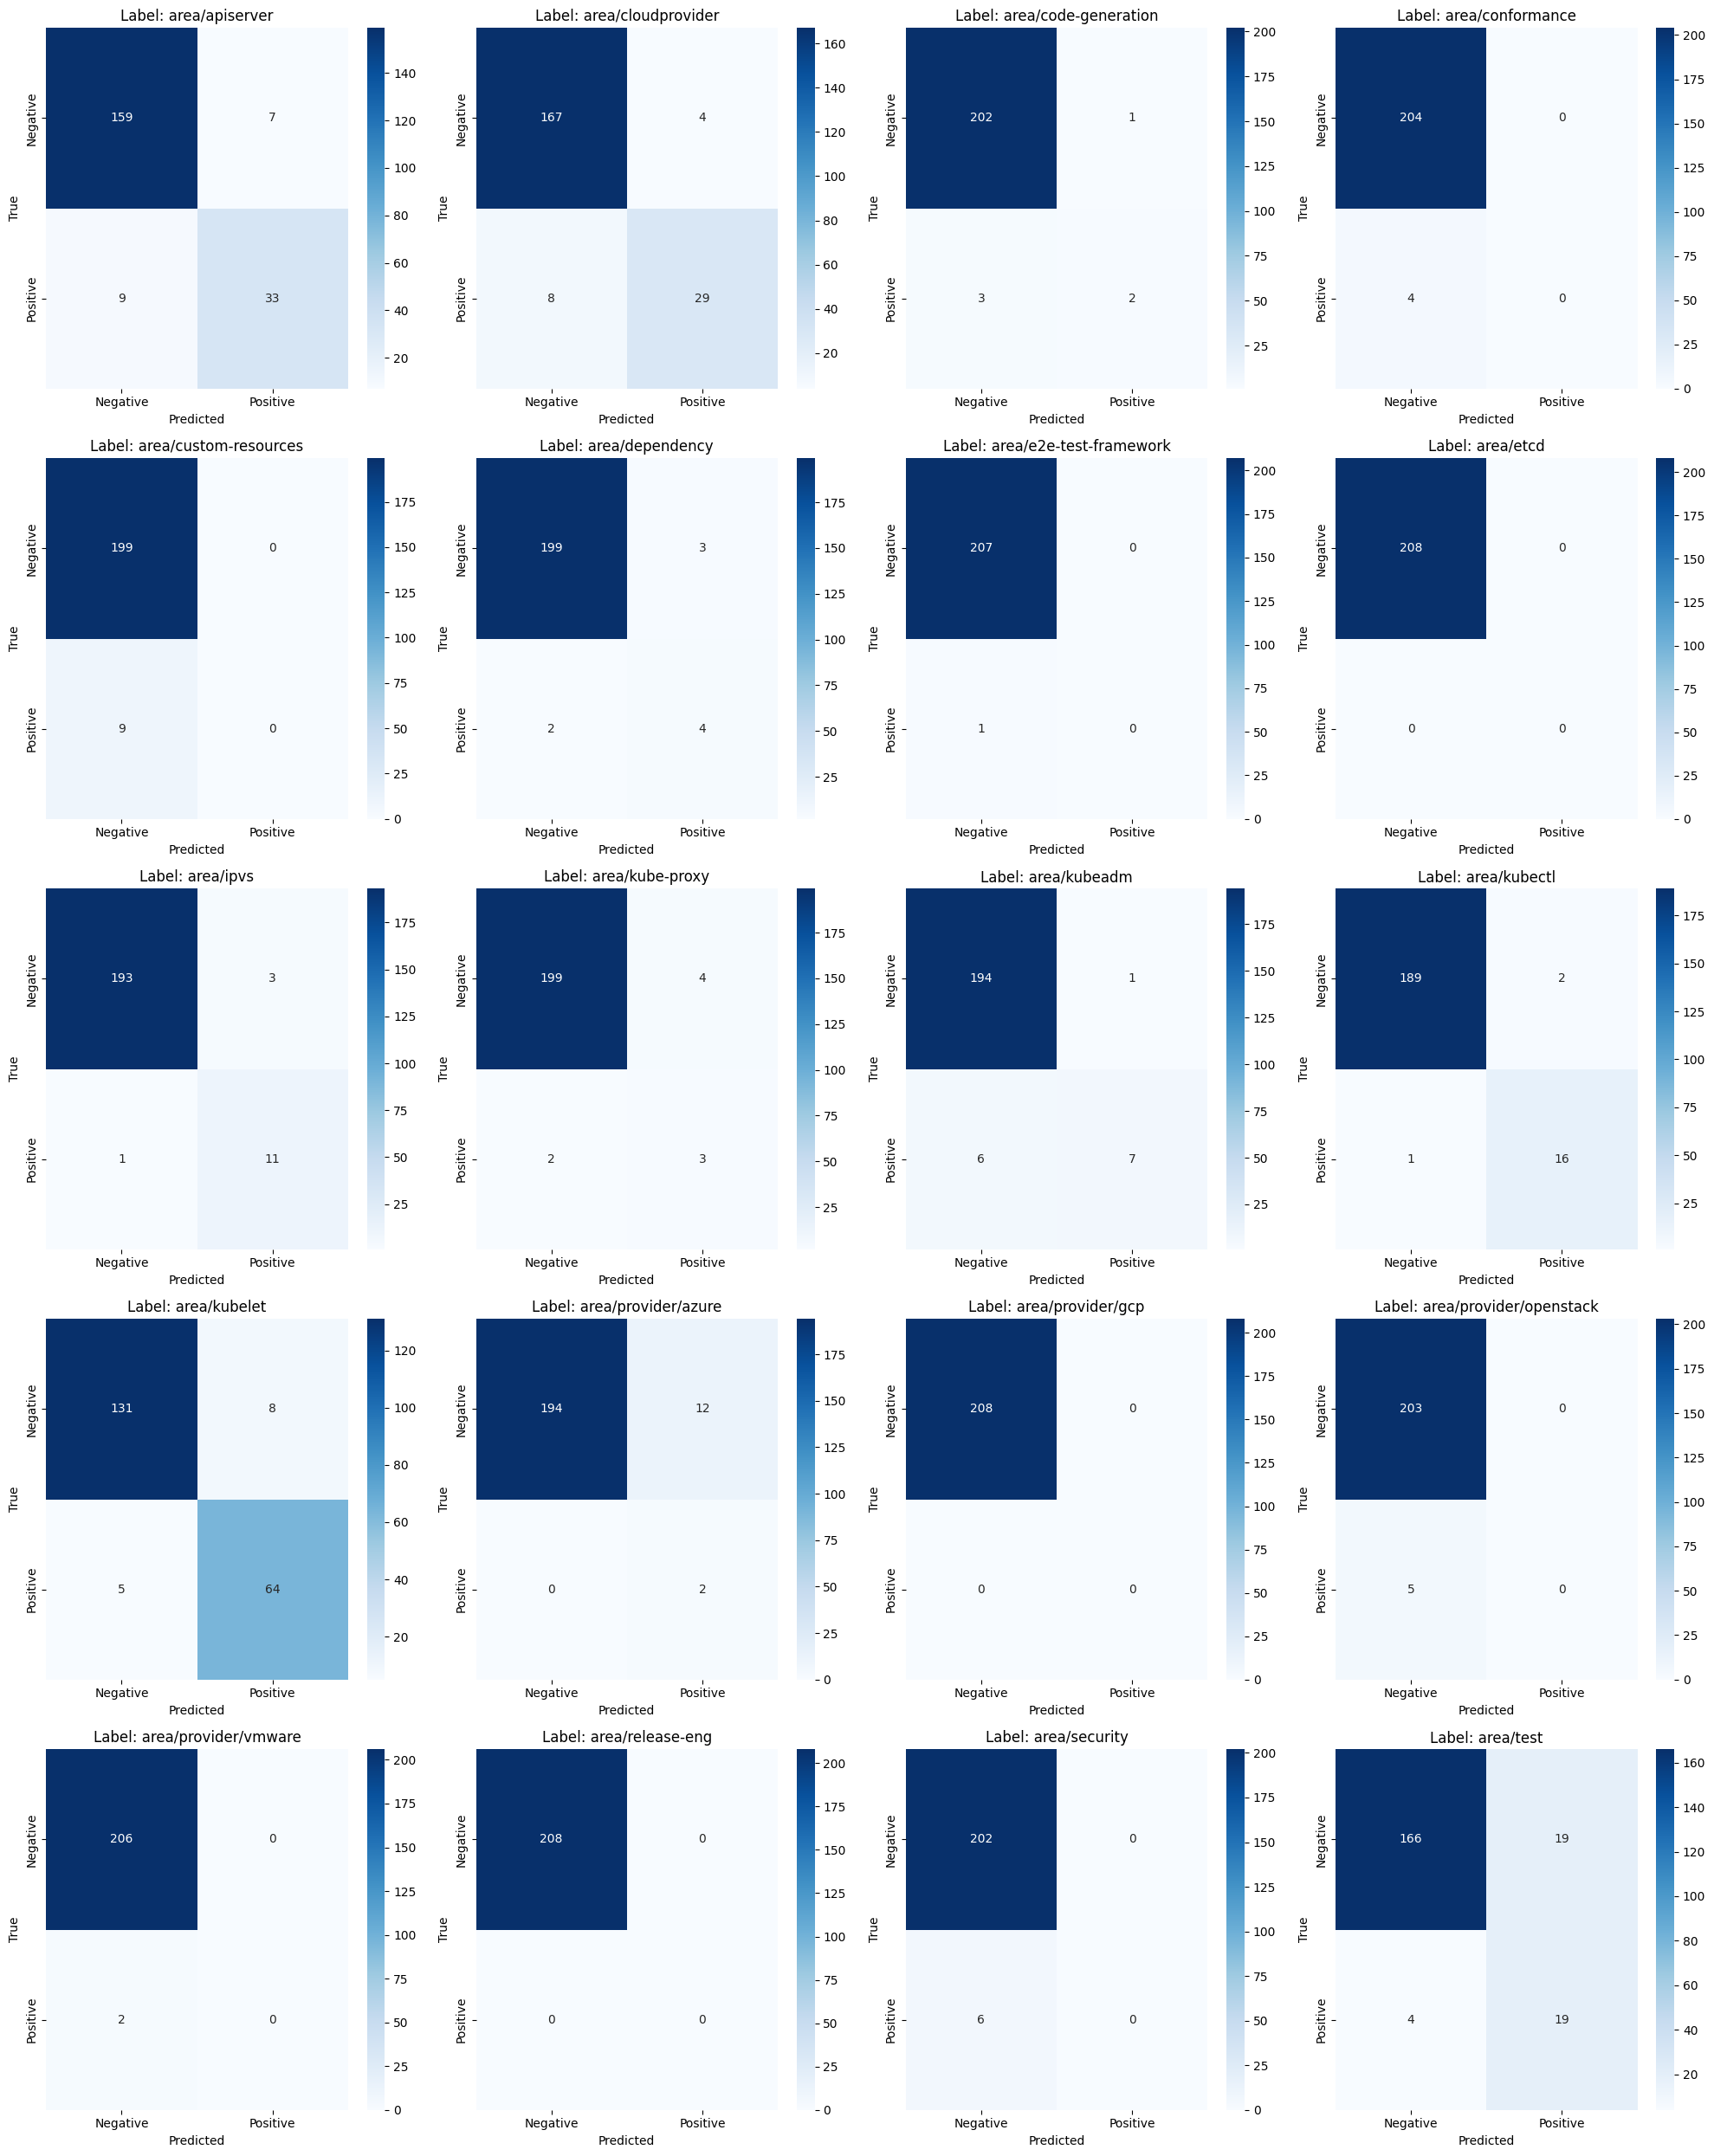

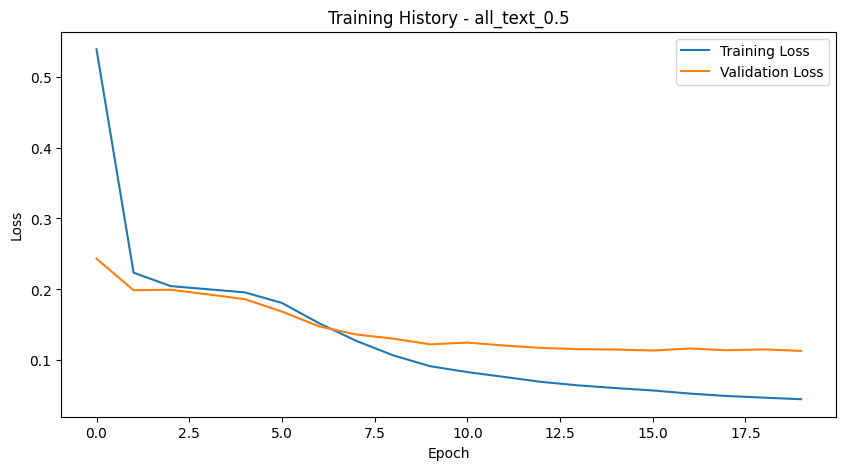

In [17]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=100,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)